In [1]:
CODE_PATH = '../../code/'
MNIST_DATA_PATH = '../../data/morphomnist/'
BASE_LOG_PATH = '../../models/morphomnist/SVIExperiment'
FIGURE_SAVE_PATH = 'figures'

# Setup

In [2]:
%matplotlib inline
import sys
import os

sys.path.append(CODE_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

import traceback
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

os.makedirs(FIGURE_SAVE_PATH, exist_ok=True)

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'

In [4]:
from datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(MNIST_DATA_PATH, train=False, columns=['thickness', 'intensity'])

In [5]:
from datasets.morphomnist.create_synth_thickness_intensity_data import model as true_model
from experiments import morphomnist
from experiments.morphomnist.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [6]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

In [7]:
from morphomnist import measure
import multiprocessing

def measure_image(x, threshold=0.5, use_progress_bar=True):
    imgs = x.detach().cpu().numpy()[:, 0]

    with multiprocessing.Pool() as pool:
        measurements = measure.measure_batch(imgs, threshold=threshold, use_progress_bar=use_progress_bar, pool=pool)

    def get_intensity(imgs, threshold):

        img_min, img_max = imgs.min(axis=(1, 2), keepdims=True), imgs.max(axis=(1, 2), keepdims=True)
        mask = (imgs >= img_min + (img_max - img_min) * threshold)

        return np.array([np.median(i[m]) for i, m in zip(imgs, mask)])

    return measurements['thickness'].values, get_intensity(imgs, threshold)

In [8]:
var_name = {'thickness': 't', 'intensity': 'i'}
value_fmt = {
    'thickness': lambda s: rf"{float(s):.1f}",
    'intensity': lambda s: rf"{int(s):d}"
}

def fmt_intervention(intervention):
    all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
    return f"$do({all_interventions})$"

# Metrics

In [9]:
metrics_df = pd.DataFrame(columns=['exp', 'loss', 'log p(x)', 'log p(intensity)', 'log p(thickness)', 'log p(z) - log q(z)', 'p(z)', 'q(z)'])
experiments = ['IndependentVISEM', 'ConditionalDecoderVISEM', 'ConditionalVISEM']

In [10]:
for exp in experiments:
    try:
        print(exp)
        metrics = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/metrics.pt')
        for k, v in metrics.items():
            print(f'{k}: {v:.0f}')
        row = {k.replace('test/', ''): np.array(v) for k, v in metrics.items()}
        metrics_df.loc[len(metrics_df)] = {'exp': exp, **row}
    except:
        traceback.print_exc()

IndependentVISEM
test/loss: 1484986
test/log p(x): -5841
test/log p(intensity): -5
test/log p(thickness): -1
test/p(z): -23
test/q(z): 55
test/log p(z) - log q(z): -78
ConditionalDecoderVISEM
test/loss: 1385213
test/log p(x): -5444
test/log p(intensity): -5
test/log p(thickness): -1
test/p(z): -22
test/q(z): 55
test/log p(z) - log q(z): -76
ConditionalVISEM
test/loss: 1427422
test/log p(x): -5611
test/log p(intensity): -4
test/log p(thickness): -1
test/p(z): -21
test/q(z): 55
test/log p(z) - log q(z): -77


In [11]:
recon_mae = {}
for exp in experiments:
    try:
        reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/reconstruction.pt')
        diff = (reconstructions['x'][:, 0]) - test_data.images
        recon_mae[exp] = np.mean(np.abs(diff.numpy()))
    except Exception as e:
        print(e)
        traceback.print_exc()
    
metrics_df.loc[:, 'recon_mae'] = list(recon_mae.values())

In [12]:
metrics_df

,exp,loss,log p(x),log p(intensity),log p(thickness),log p(z) - log q(z),p(z),q(z),recon_mae
0,IndependentVISEM,1484985.716890335,-5841.1855,-5.190583,-0.93462527,-77.95415,-22.762169,55.19198,4.503220
1,ConditionalDecoderVISEM,1385213.361749649,-5444.091,-5.191461,-0.93461645,-76.279106,-21.76091,54.51819,4.260283
2,ConditionalVISEM,1427422.414145279,-5611.178,-4.303378,-0.93390065,-76.526855,-21.416119,55.11075,4.432856


# Load Models

In [13]:
models = {'true': true_model,}

loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_0/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hparams']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

# Dataset Samples

In [14]:
def plot_img_grid(samples, save_name, annotate=True, num_cols=4, num_rows=4):
    num = num_cols * num_rows

    fig = plt.figure(figsize=(num_cols * 1., num_rows * 1.))
    gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

    for i in range(num):
        x = samples['x'][i]
        
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        if annotate:
            thickness = samples['thickness'][i].item()
            intensity = samples['intensity'][i].item()
            ax.set_title(f'$t={thickness:.1f}; i={intensity:.0f}$', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight')
    
    plt.show()

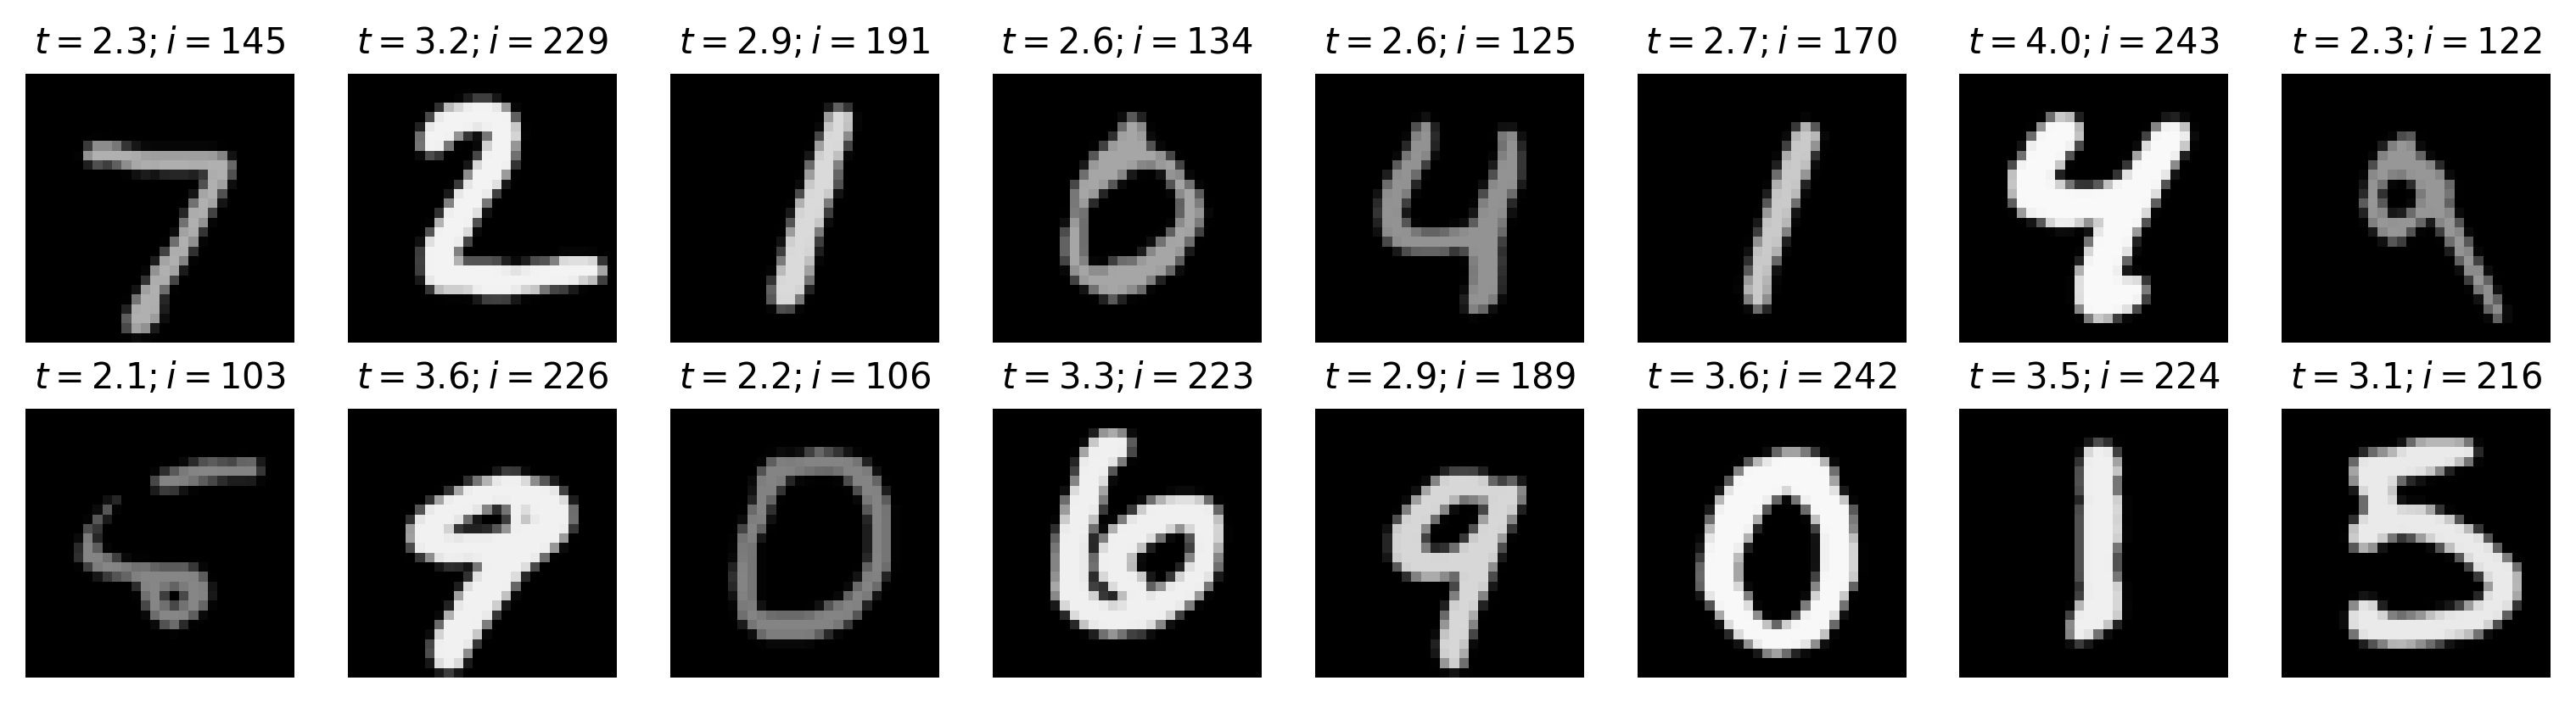

In [15]:
idx = 0

num_cols = 8
num_rows = 2

num = num_cols * num_rows

samples = {
    'x': test_data[idx:idx+num]['image'],
    'thickness': test_data[idx:idx+num]['thickness'],
    'intensity': test_data[idx:idx+num]['intensity'],
}

save_name = 'synth_mnist_samples'

fig = plt.figure(figsize=(num_cols * 1.6, num_rows * 1.6))
gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

for i in range(num):
    x = samples['x'][i]

    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    thickness = samples['thickness'][i].item()
    intensity = samples['intensity'][i].item()
    ax.set_title(f'$t={thickness:.1f}; i={intensity:.0f}$', fontsize=10)
    ax.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Unconditional Samples

IndependentVISEM


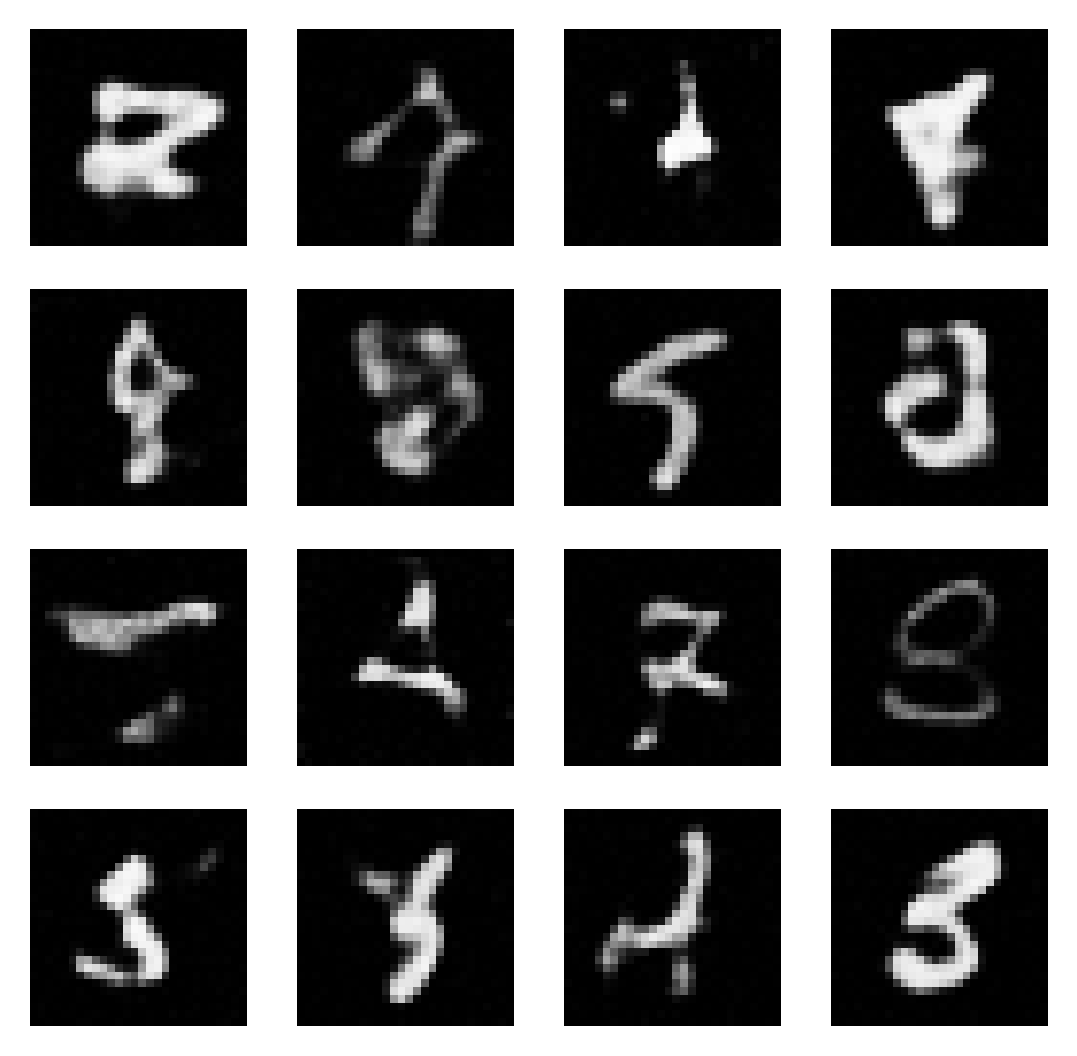

ConditionalDecoderVISEM


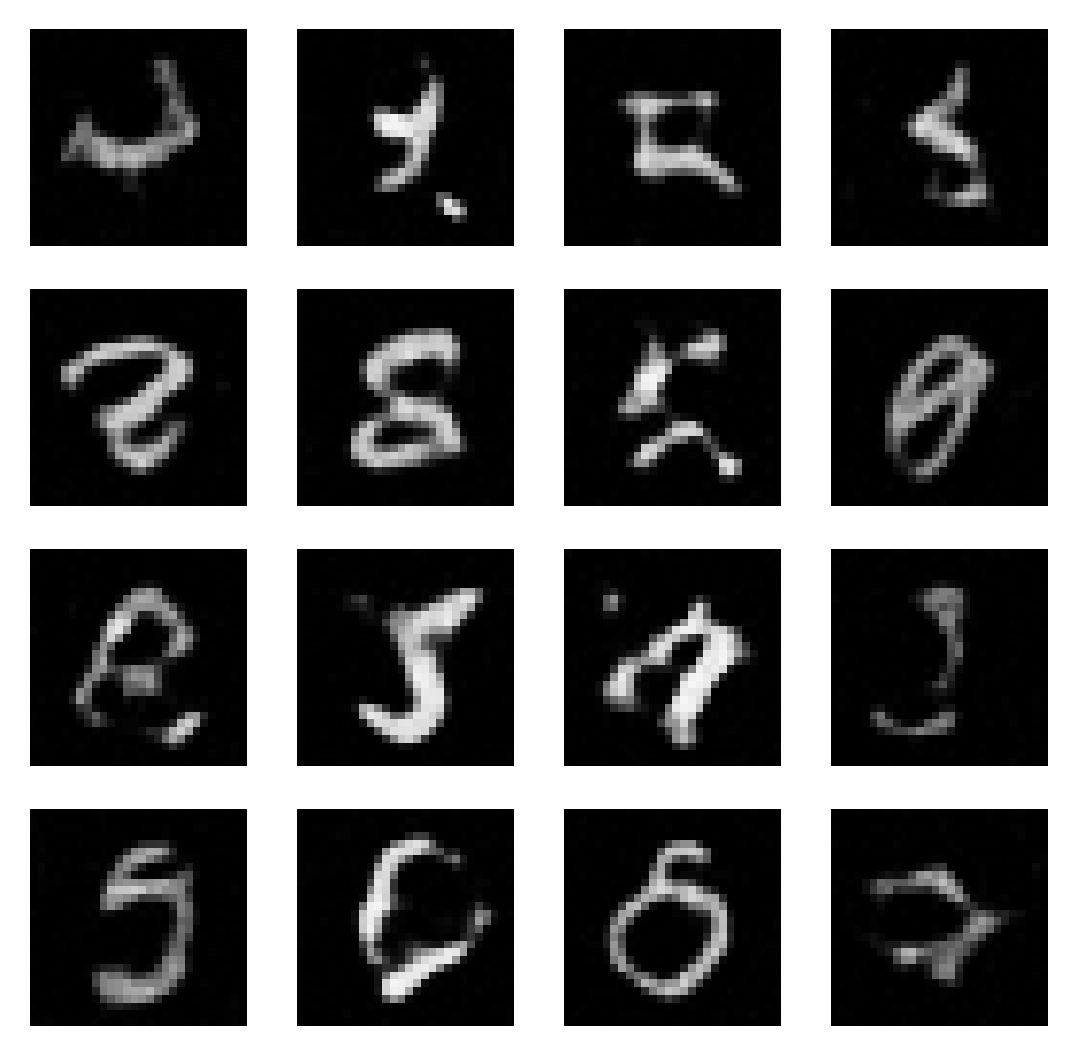

ConditionalVISEM


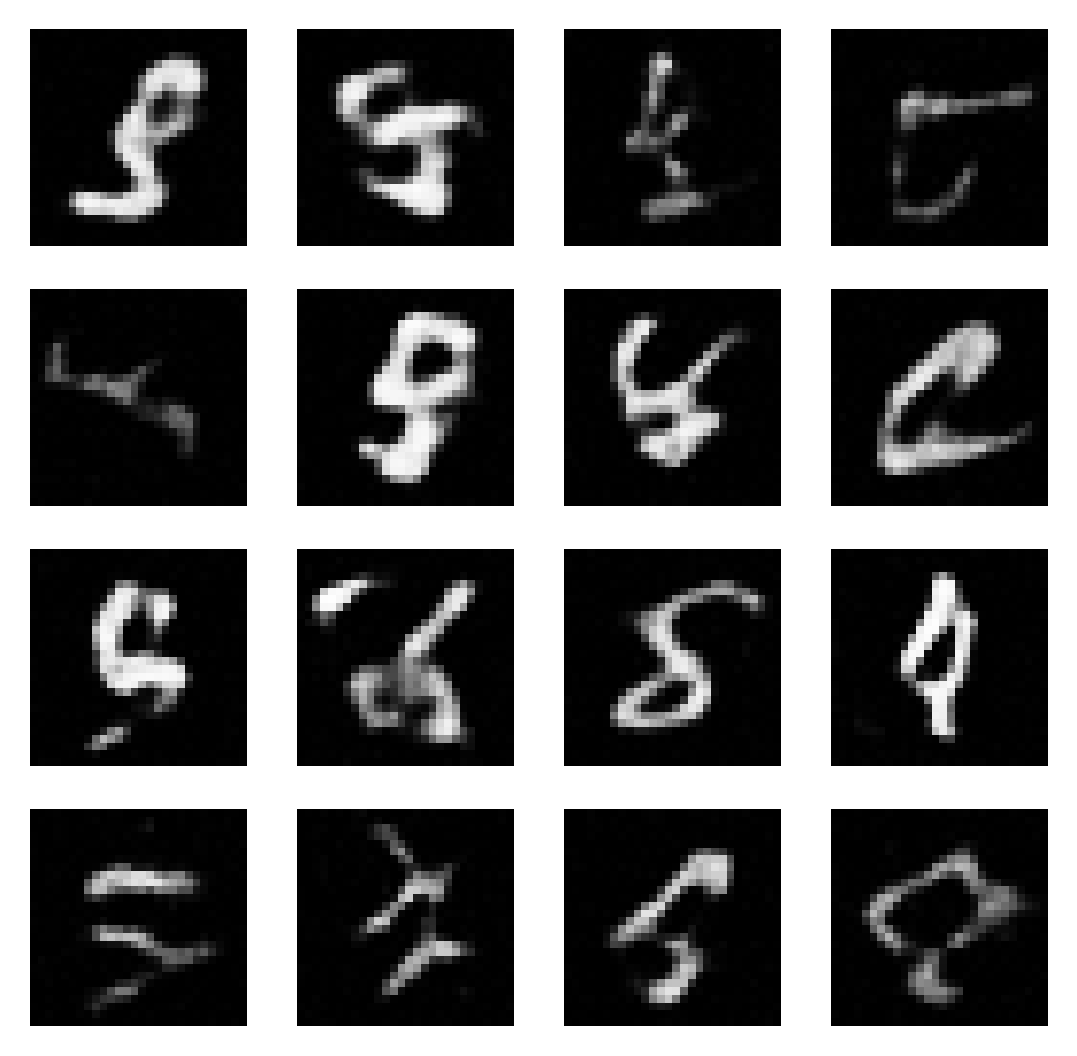

In [16]:
num_cols = 4
num_rows = 4
num = num_cols * num_rows
for exp in loaded_models.keys():
    print(exp)

    samples = loaded_models[exp].sample(num)
        
    samples = {
        'x': samples[0],
        'thickness': samples[2],
        'intensity': samples[3]
    }
    
    save_name = f'{exp}_uncond_samples'

    fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
    gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

    for i in range(num):
        x = samples['x'][i]
        
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        ax.axis('off')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
    
    plt.show()

# Conditional Samples

IndependentVISEM


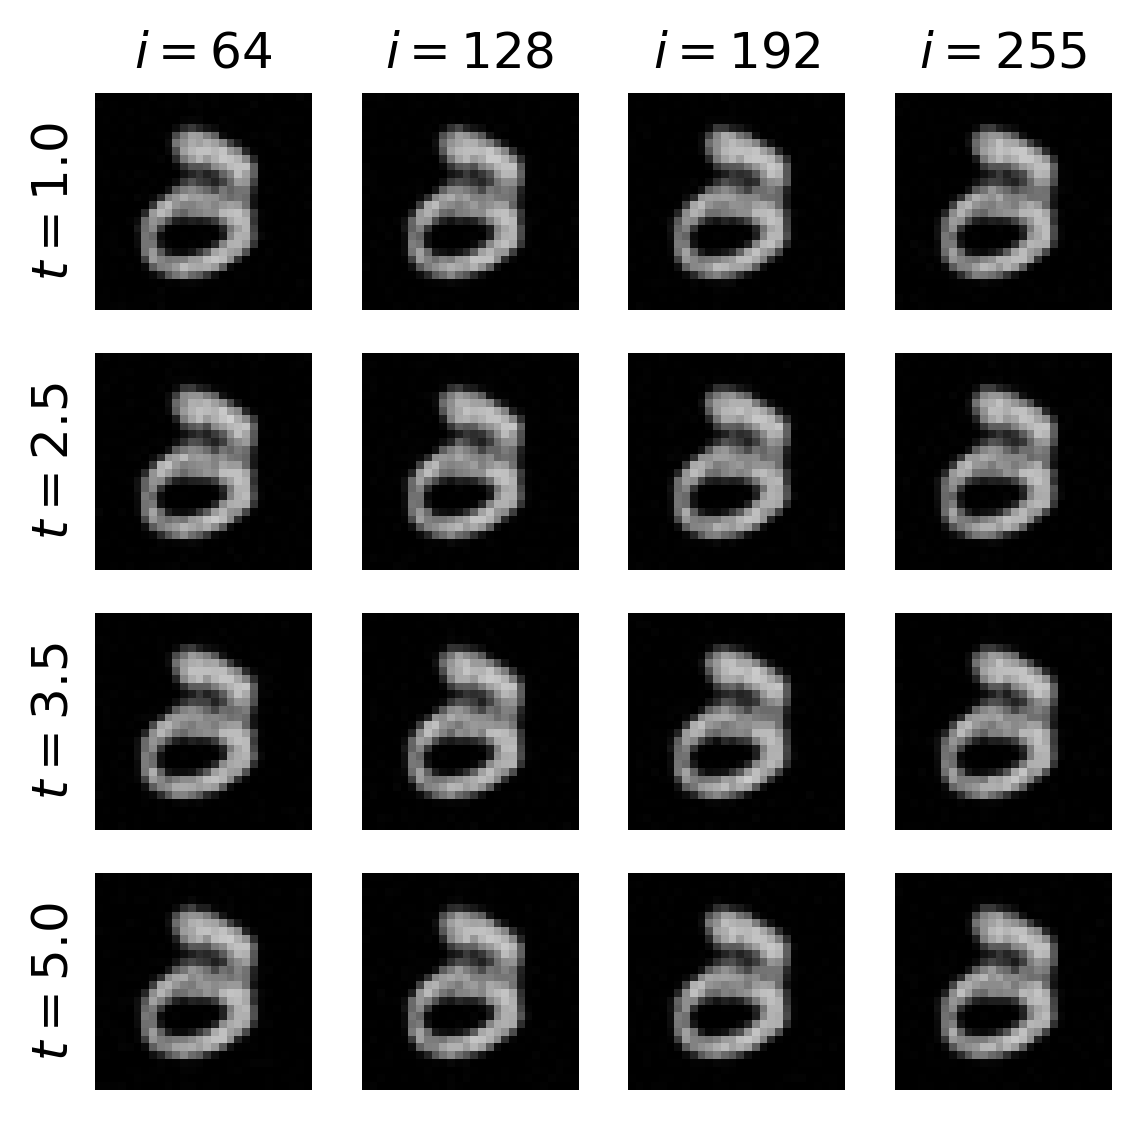

ConditionalDecoderVISEM


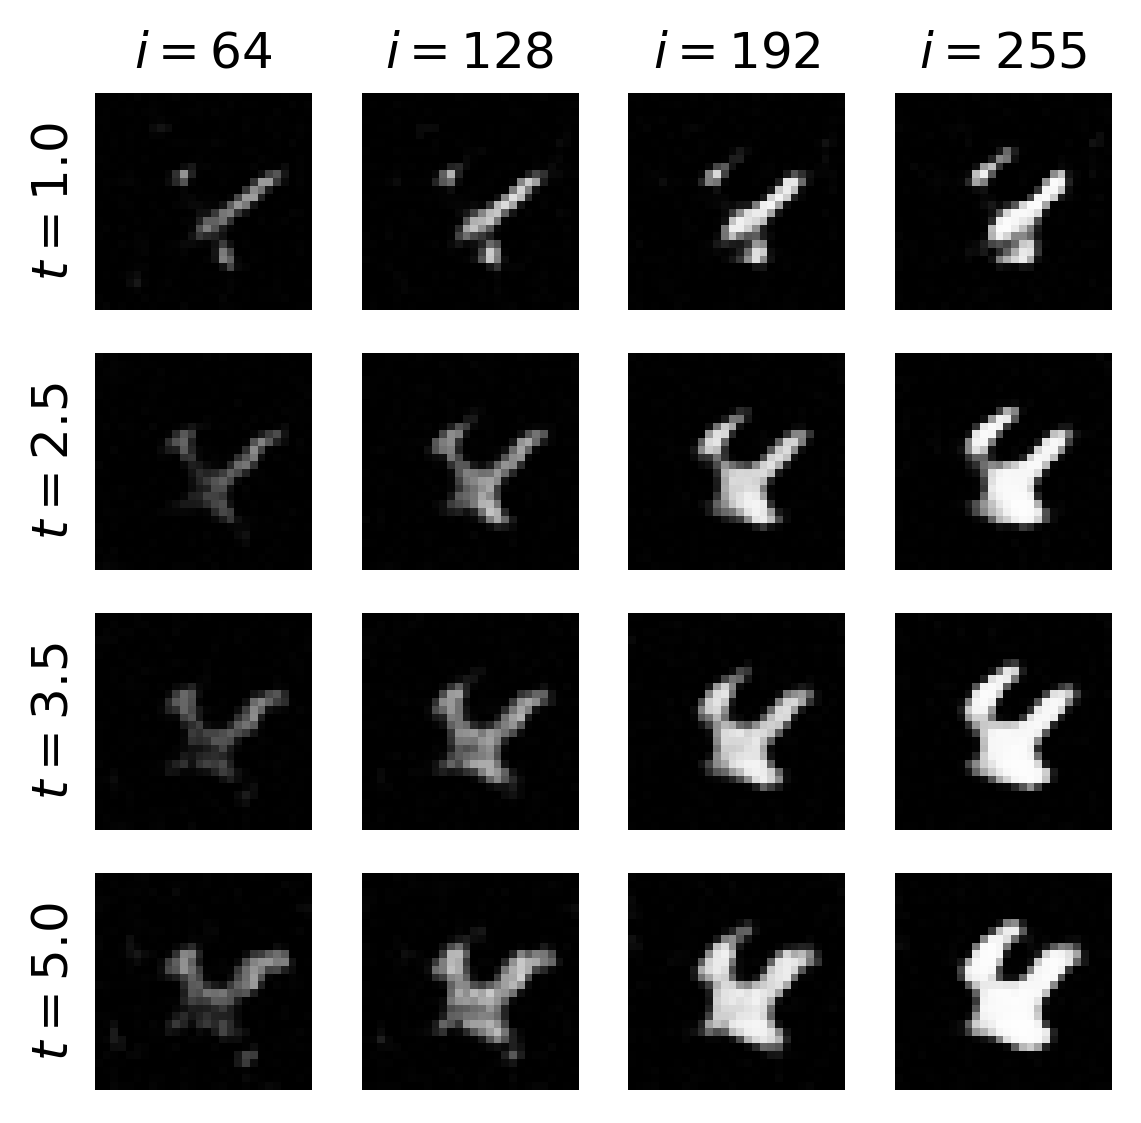

ConditionalVISEM


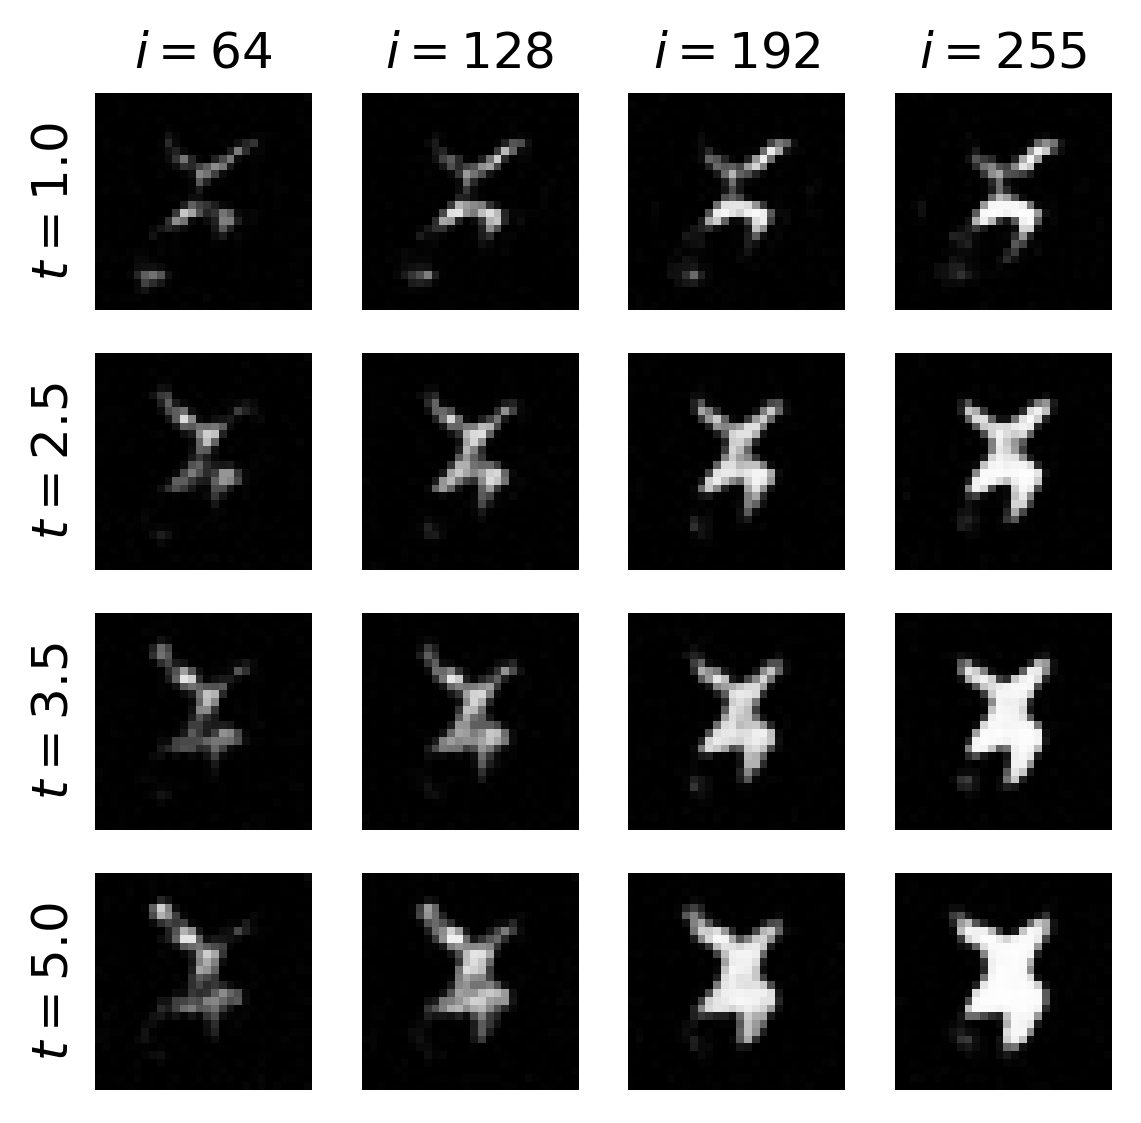

In [17]:
for exp in loaded_models.keys():
    if 'Indep' in exp:
        pass
        #continue

    print(exp)

    thickness_range = [1., 2.5, 3.5, 5.]
    intensity_range = [64, 128, 192, 255]
    
    samples = {
        'x': [],
        'thickness': [],
        'intensity': [],
        
    }

    z = loaded_models[exp].sample(1)[1]

    for i, thickness in enumerate(thickness_range):
        for j, intensity in enumerate(intensity_range):
            thickness = torch.tensor([[thickness]])
            intensity = torch.tensor([[intensity]])
            data = {'z': z, 'thickness': thickness, 'intensity': intensity}

            x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
            samples['x'] += [x]
            samples['thickness'] += [thickness]
            samples['intensity'] += [intensity]

    save_name = f'{exp}_cond_samples'
    
    num_cols = len(thickness_range)
    num_rows = len(intensity_range)
    num = num_cols * num_rows

    fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
    gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

    for i in range(num):
        x = samples['x'][i]
        
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(x.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        if (i % num_cols) == 0:
            thickness = samples['thickness'][i].item()
            ax.set_ylabel(f'$t={thickness:.1f}$', fontsize=mpl.rcParams['axes.titlesize'])
            for s in ['top', 'right']:
                ax.spines[s].set_visible(False)
            for s in ['left', 'top', 'right']:
                ax.spines[s].set_visible(False)
            for s in ['top', 'right', 'bottom']:
                ax.spines[s].set_visible(False)
            ax.yaxis.grid(False)
            ax.xaxis.grid(False)
            plt.setp(ax.yaxis.get_majorticklines(), visible=False)
            plt.setp(ax.yaxis.get_minorticklines(), visible=False)
            plt.setp(ax.xaxis.get_majorticklines(), visible=False)
            plt.setp(ax.xaxis.get_minorticklines(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            ax.axis('off')
        if i // num_cols == 0:
            intensity = samples['intensity'][i].item()
            ax.set_title(f'$i={intensity:.0f}$')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
    
    plt.show()

# Reconstructions

IndependentVISEM
ConditionalDecoderVISEM
ConditionalVISEM


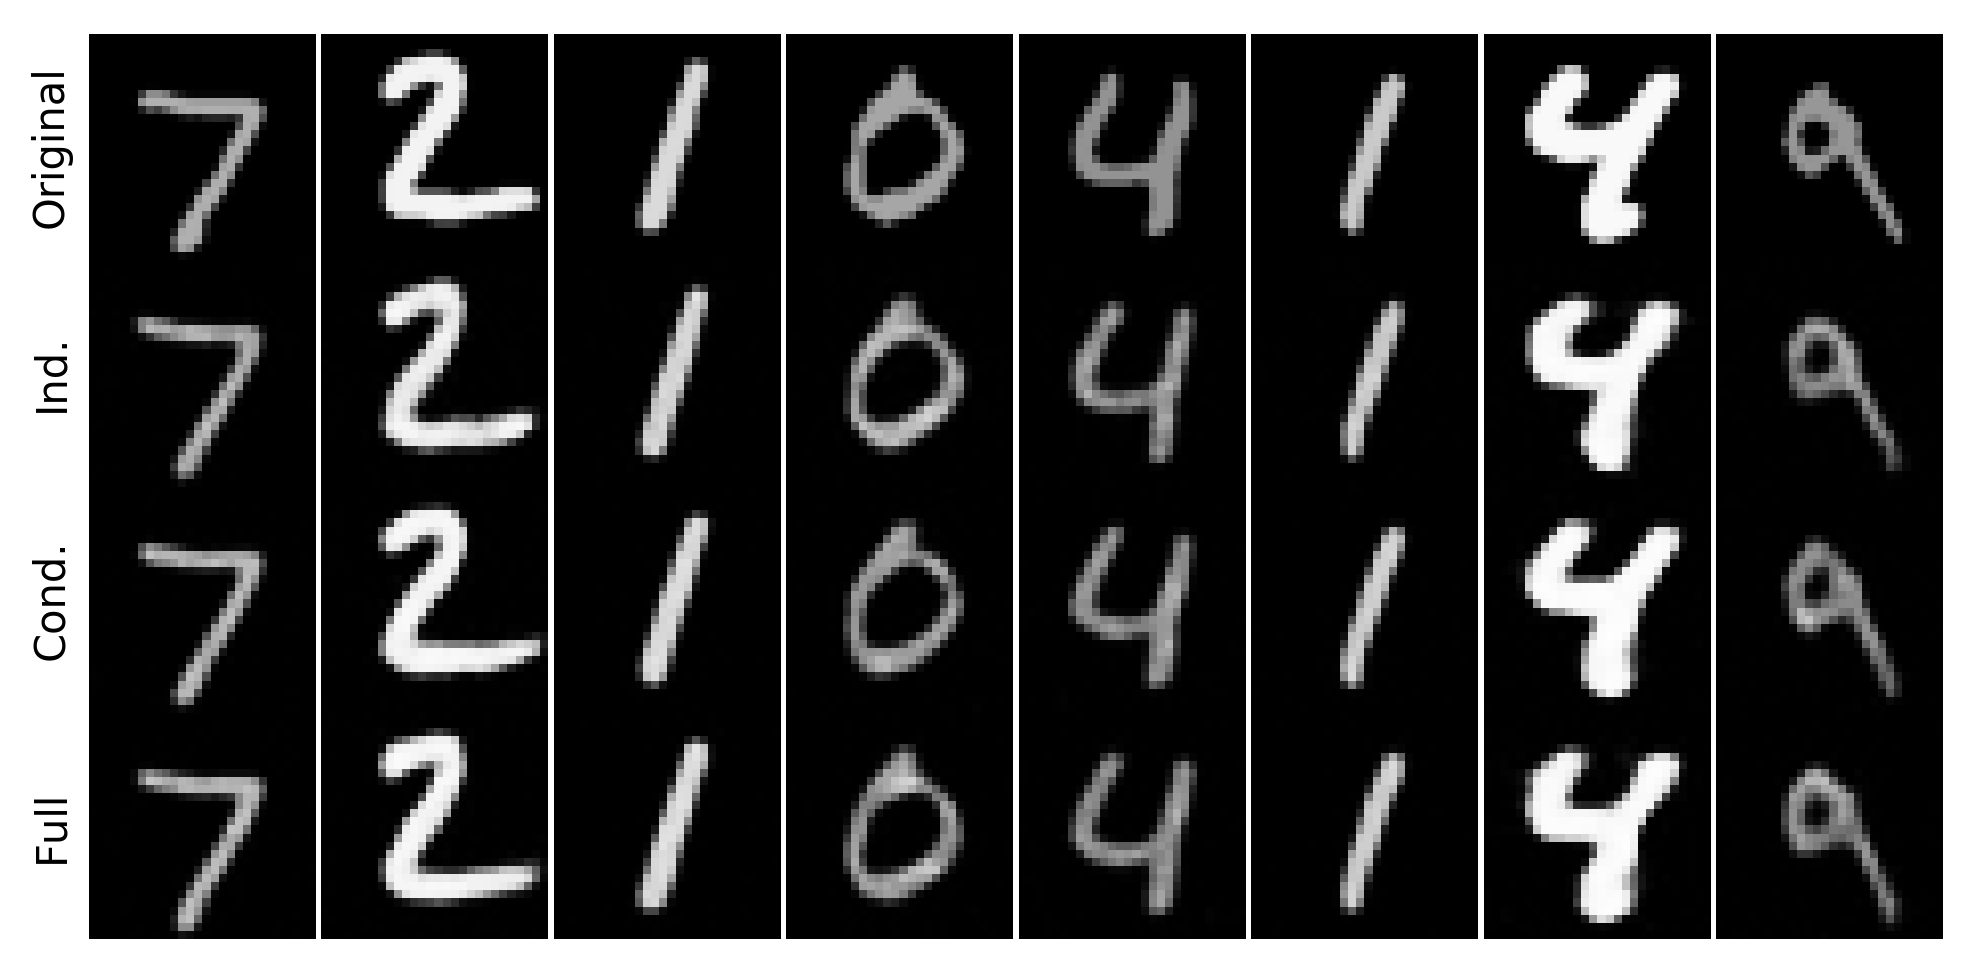

In [18]:
num_samples = 8

titles = {
    'IndependentVISEM': 'Ind.',
    'ConditionalDecoderVISEM': 'Cond.',
    'ConditionalVISEM': 'Full',
}

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 4 * 1.))

gs = fig.add_gridspec(4, num_samples, wspace=0., hspace=0.0)

for i in range(num_samples):
    img = test_data[i]['image']
    
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(img.numpy().squeeze(), img_cm, vmin=0, vmax=255)
    if i == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
        
for j, exp in enumerate(loaded_models.keys()):
    print(exp)
    reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_0/reconstruction.pt')
    
    for i in range(num_samples):
        img = reconstructions['x'][i]

        ax = fig.add_subplot(gs[j + 1, i])
        ax.imshow(img.numpy().squeeze(), img_cm, vmin=0, vmax=255)
        if i == 0:
            ax.set_ylabel(titles[exp])
            for s in ['top', 'right']:
                ax.spines[s].set_visible(False)
            for s in ['left', 'top', 'right']:
                ax.spines[s].set_visible(False)
            for s in ['top', 'right', 'bottom']:
                ax.spines[s].set_visible(False)
            ax.yaxis.grid(False)
            ax.xaxis.grid(False)
            plt.setp(ax.yaxis.get_majorticklines(), visible=False)
            plt.setp(ax.yaxis.get_minorticklines(), visible=False)
            plt.setp(ax.xaxis.get_majorticklines(), visible=False)
            plt.setp(ax.xaxis.get_minorticklines(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            ax.axis('off')
            
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Measured Covariates

In [19]:
covariate_measures = {}

# true
measured_thickness, measured_intensity = measure_image(test_data[:]['image'].unsqueeze(1))


covariate_measures['true'] = {
    'thickness': test_data[:]['thickness'].numpy().squeeze(),
    'intensity': test_data[:]['intensity'].numpy().squeeze(),
    'measured_thickness': measured_thickness,
    'measured_intensity': measured_intensity,
}

# models
for exp in loaded_models.keys():
    print(exp)
    num = len(test_data)
    
    samples = loaded_models[exp].sample(num)
    
    measured_thickness, measured_intensity = measure_image(samples[0])
        
    covariate_measures[exp] = {
        'thickness': samples[2].numpy().squeeze(),
        'intensity': samples[3].numpy().squeeze(),
        'measured_thickness': measured_thickness,
        'measured_intensity': measured_intensity,
    }

100%|##########| 10000/10000 [01:57<00:00, 85.42img/s]  


IndependentVISEM


100%|##########| 10000/10000 [01:56<00:00, 85.51img/s]  


ConditionalDecoderVISEM


100%|##########| 10000/10000 [01:56<00:00, 85.96img/s]  


ConditionalVISEM


100%|##########| 10000/10000 [01:55<00:00, 86.32img/s]  


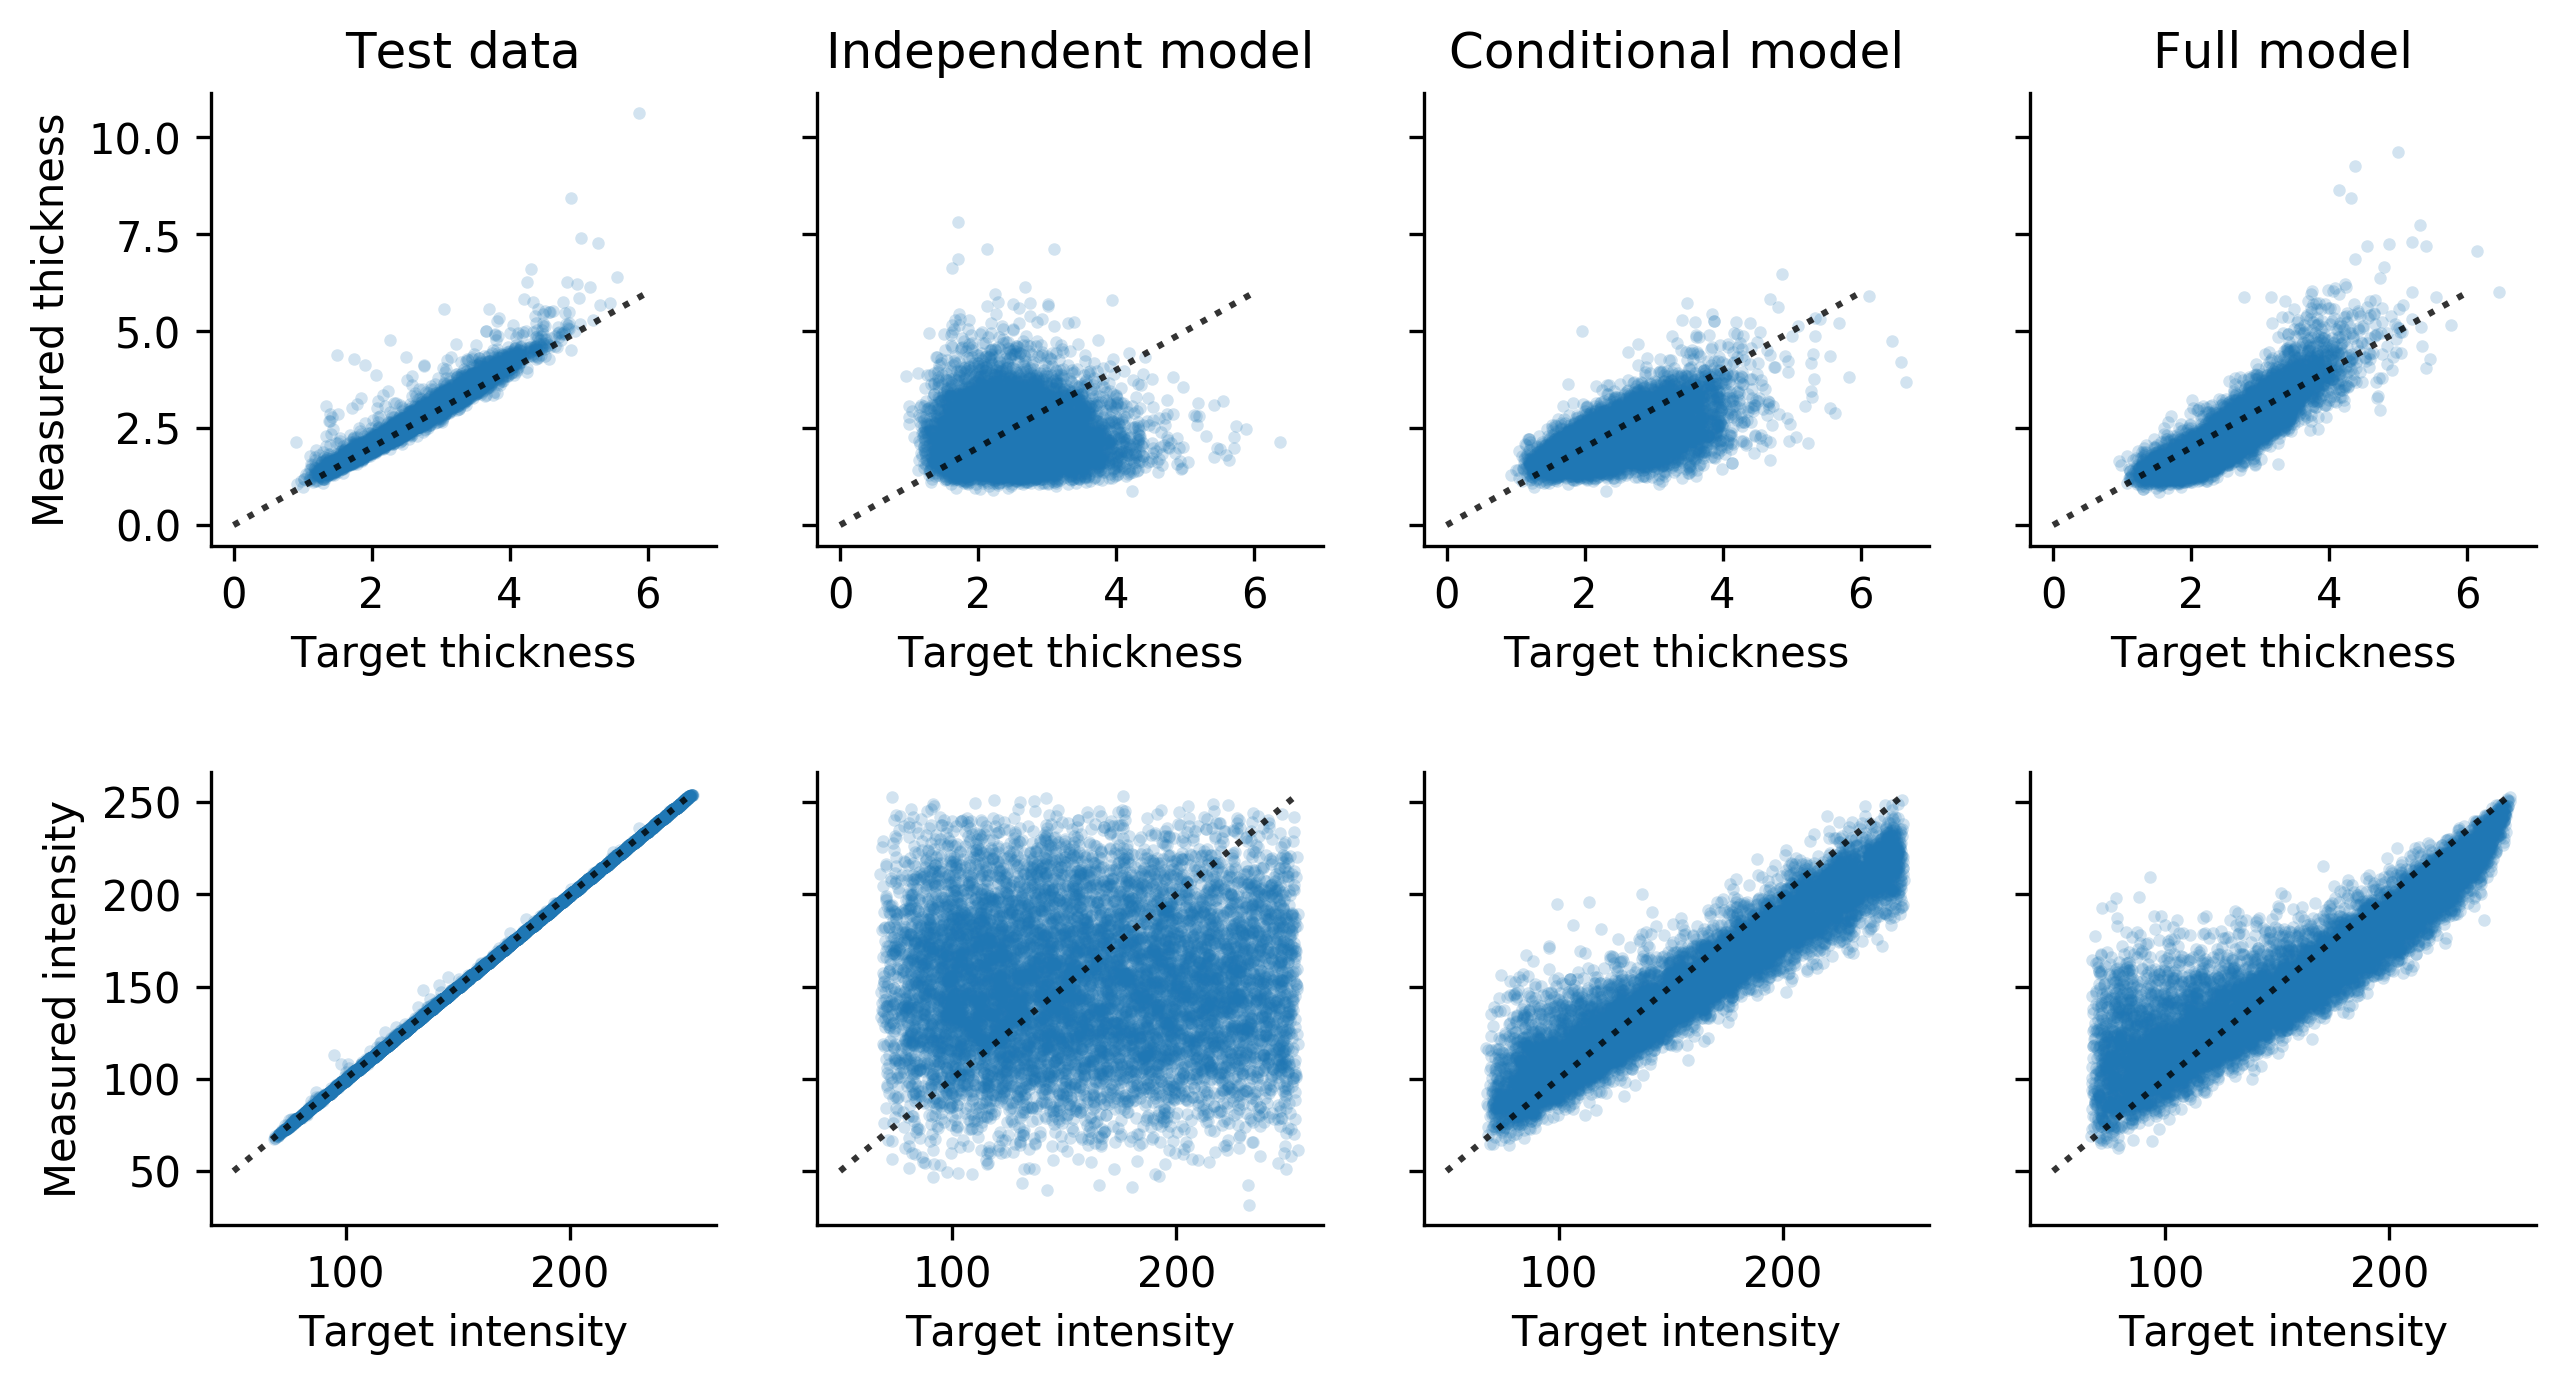

In [20]:
save_name = 'covariate_measures'

titles = {
    'true': 'Test data',
    'IndependentVISEM': 'Independent model',
    'ConditionalDecoderVISEM': 'Conditional model',
    'ConditionalVISEM': 'Full model',
}

fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex='row', sharey='row', gridspec_kw=dict(hspace=0.5))


for i, (s, m) in enumerate(covariate_measures.items()):
    ax_thick = ax[0, i]
    
    thickness = m['thickness']
    measured_thickness = m['measured_thickness']
    intensity = m['intensity']
    measured_intensity = m['measured_intensity']
    
    ax_thick.plot(thickness, measured_thickness, 'o', alpha=0.2, mew=0, ms=3, rasterized=True)
    ax_thick.plot([0., 6.], [0., 6.], ':', color='black', alpha=0.8)
    ax_thick.set_xlabel('Target thickness')
    
    ax_thick.set_title(titles[s])

    ax_int = ax[1, i]
    ax_int.plot(intensity, measured_intensity, 'o', alpha=0.2, mew=0, ms=3, rasterized=True)
    int_min= 50.
    ax_int.plot([int_min, 255.], [int_min, 255.], ':', color='black', alpha=0.8, rasterized=True)
    ax_int.set_xlabel('Target intensity')

ax[0, 0].set_ylabel('Measured thickness')
ax[1, 0].set_ylabel('Measured intensity')

sns.despine()
plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight')

plt.show()

# Intervention KDEs

In [21]:
prob_maps = {}

intensity_range = torch.arange(64, 255, 0.5, dtype=torch.float)
thickness_range = torch.arange(.5, 5, 0.01, dtype=torch.float)

num_intensity = intensity_range.shape[0]
num_thickness = thickness_range.shape[0]

intensity_range = intensity_range.repeat(num_thickness).unsqueeze(1)
thickness_range = thickness_range.repeat_interleave(num_intensity).unsqueeze(1)

for k, model in models.items():
    prob_maps[k] = {}

    if k == 'true':
        cond_data = {
            'thickness': thickness_range[:, 0] -.5,
            'intensity': intensity_range[:, 0]
        }
    else:
        cond_data = {
            'thickness': thickness_range,
            'intensity': intensity_range
        }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(model, data=cond_data)).get_trace(num_intensity*num_thickness)
        trace.compute_log_prob()
    
    log_prob = trace.nodes['thickness']['log_prob'] + trace.nodes['intensity']['log_prob']
    
    orig_thickness_fn = trace.nodes['thickness']['fn']
    orig_intensity_fn = trace.nodes['intensity']['fn']

    prob_maps[k]['$p(t, i)$'] = {
        'log_prob': log_prob, 'intensity': trace.nodes['_RETURN']['value'][1], 'thickness': trace.nodes['_RETURN']['value'][0]
    }
    
    intervention_data = {'thickness': cond_data['thickness'] + 1}
    
    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pyro.do(model, data=intervention_data), data=cond_data)).get_trace(num_intensity*num_thickness)
        trace.compute_log_prob()
    
    log_prob = trace.nodes['thickness']['log_prob'] + trace.nodes['intensity']['log_prob']
    prob_maps[k]['$p(t, i\,|\,do(t + 1))$'] = {
        'log_prob': log_prob, 'intensity': trace.nodes['_RETURN']['value'][1], 'thickness': trace.nodes['_RETURN']['value'][0]
    }
    
    intervention_data = {'thickness': np.clip(cond_data['thickness'] - 0.5, 0., 10)}
    
    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(pyro.do(model, data=intervention_data), data=cond_data)).get_trace(num_intensity*num_thickness)
        trace.compute_log_prob()
    
    log_prob = trace.nodes['thickness']['log_prob'] + trace.nodes['intensity']['log_prob']
    prob_maps[k]['$p(t, i\,|\,do(t - 0.5))$'] = {
        'log_prob': log_prob, 'intensity': trace.nodes['_RETURN']['value'][1], 'thickness': trace.nodes['_RETURN']['value'][0]
    }

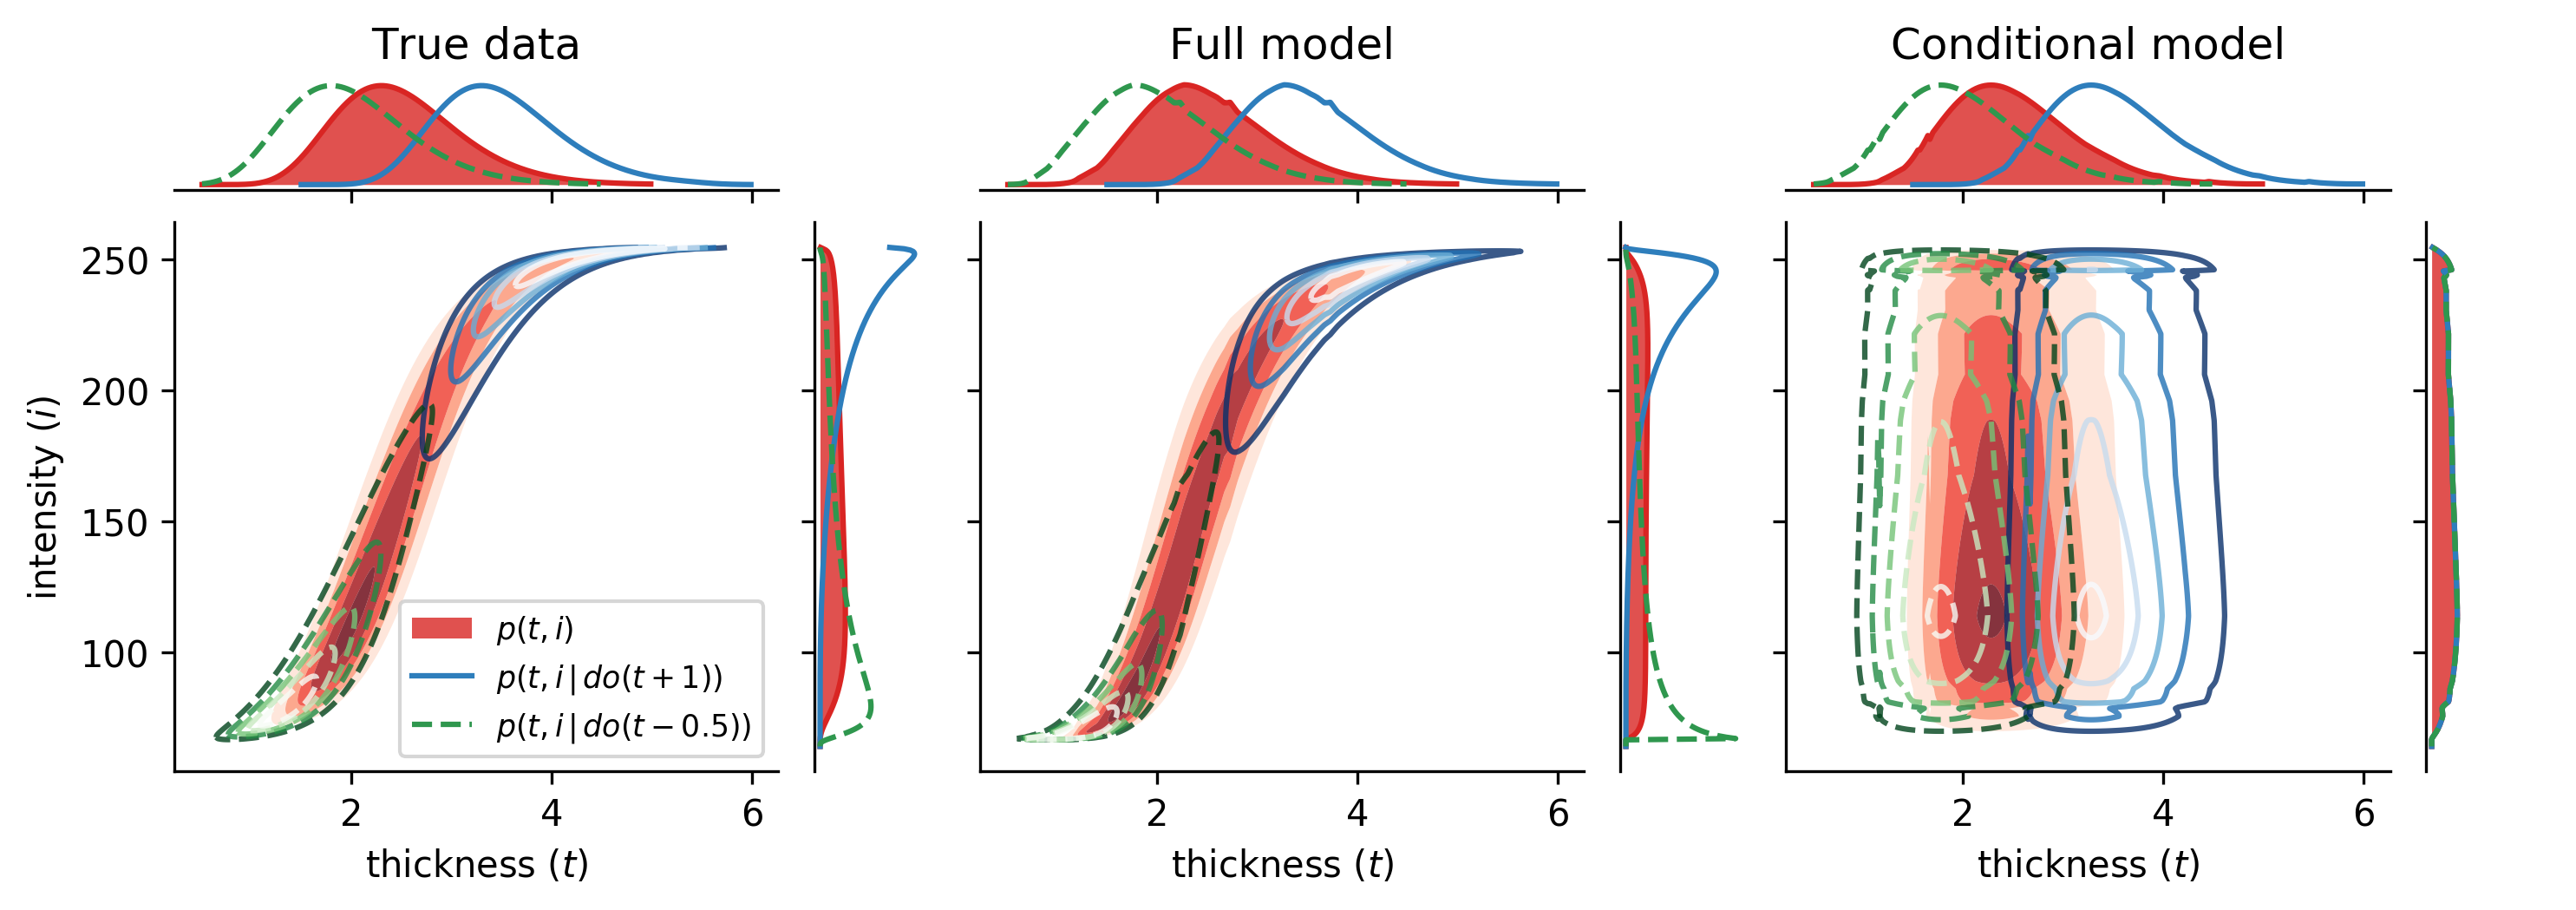

In [22]:
from matplotlib.colors import ListedColormap

def make_transparent_cmap(cmap):
    n = 256
    colours = cmap(np.linspace(0, 1, n))
    colours[:, -1] = np.linspace(0, 1, n)
    return ListedColormap(colours)    

def plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y):
    contours = []
    for j, (k, v) in enumerate(prob_maps[exp].items()):
        thickness = v['thickness'].reshape(num_thickness, num_intensity).numpy()
        intensity = v['intensity'].reshape(num_thickness, num_intensity).numpy()
        log_prob = v['log_prob'].reshape(num_thickness, num_intensity).numpy()
        prob = np.exp(log_prob)

        valid = thickness[:, 0] > .5
        thickness = thickness[valid, :]
        intensity = intensity[valid, :]
        log_prob = log_prob[valid, :]
        prob = prob[valid, :]
        
        dt = thickness[1, 0] - thickness[0, 0]
        di = intensity[0, 1] - intensity[0, 0]
        marg_t = prob.sum(1) * dt
        marg_i = prob.sum(0) * di
        
        mi = prob.min()
        ma = np.percentile(prob.flat, 99.5)
        step = (ma - mi) / 5
        levels = np.arange(mi, ma, step) + step
        
        filled = j == 0
        cmap = cmaps[j]
        colour = cmap(.7)
        
        alpha = .8
        if filled:
            ax_joint.contourf(thickness, intensity, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')
            c = ax_marg_x.fill_between(thickness[:, 0], marg_t, color=colour, lw=0, alpha=alpha)
            ax_marg_y.fill_betweenx(intensity[0, :], marg_i, color=colour, lw=0, alpha=alpha)
        else:
            kwargs = dict(cmap=cmap.reversed(), antialiased=True, levels=levels, alpha=alpha)
            if j == 2:
                kwargs['linestyles'] = 'dashed'
            c = ax_joint.contour(thickness, intensity, prob, **kwargs)
        
        kwargs = dict(ls='--') if j == 2 else {}
        h, = ax_marg_x.plot(thickness[:, 0], marg_t, c=colour, **kwargs)
        ax_marg_y.plot(marg_i, intensity[0, :], c=colour, **kwargs)
        
        if filled:
            contours.append(c)
        else:
            contours.append(h)

    ax_marg_x.set_title(titles[exp])
    ax_joint.set_xlabel('thickness ($t$)', fontsize='medium')
    if i == 0:
        ax_joint.set_ylabel('intensity ($i$)', fontsize='medium')
        ax_joint.legend(contours, prob_maps[exp].keys(), loc='lower right', fontsize='small')

def plot_all_joints():
    n_exp = len(titles)
    fig = plt.figure(figsize=(10, 3.6))
    ratio = 5
    global_gs = fig.add_gridspec(1, n_exp)
    
    ax_joint0 = ax_marg_x0 = ax_marg_y0 = None

    margin = 0.02 / n_exp
    width = 1. / n_exp
    for i, exp in enumerate(titles.keys()):
        gs = global_gs[i].subgridspec(2, 2, width_ratios=[ratio, 1], height_ratios=[1, ratio],
                                   wspace=0.1, hspace=0.1)

        ax_joint = fig.add_subplot(gs[1, 0], sharex=ax_joint0, sharey=ax_joint0)
        ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint0, sharey=ax_marg_x0)
        ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint0, sharex=ax_marg_y0)
        if i == 0:
            ax_joint0 = ax_joint
            ax_marg_x0 = ax_marg_x
            ax_marg_y0 = ax_marg_y
        
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_y.get_yticklabels(), visible=False)
        
        # Turn off the ticks on the density axis for the marginal plots
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_y.get_xticklabels(), visible=False)
        for s in ['top', 'right']:
            ax_joint.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax_marg_x.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax_marg_y.spines[s].set_visible(False)
        ax_marg_x.yaxis.grid(False)
        ax_marg_y.xaxis.grid(False)
        
        if i > 0:
            plt.setp(ax_joint.get_yticklabels(), visible=False)

        plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y)
    
    fig.tight_layout()

titles = {'true': 'True data', 'ConditionalVISEM': 'Full model', 'ConditionalDecoderVISEM': 'Conditional model'}
plot_all_joints()
plt.savefig(f'{FIGURE_SAVE_PATH}/morphomnist_do_t.pdf')
plt.show();

# Intervention vs Condition

In [23]:
def my_violinplot(var, val, loc, ax=None, vert=False, width=None, fill_kw=None, line_kw=None):
    if ax is None:
        ax = plt.gca()
    if width is not None:
        val = .5 * width * val / max(val)
    fill_kw_ = dict()  # defaults
    fill_kw_.update(fill_kw or {})
    line_kw_ = dict()  # defaults
    line_kw_.update(line_kw or {})
    if vert:
        fh = ax.fill_betweenx(var, loc - val, loc + val, **fill_kw_)
        lh, = ax.plot([loc, loc], [min(var), max(var)], **line_kw_)
    else:
        fh = ax.fill_between(var, loc - val, loc + val, **fill_kw_)
        lh, = ax.plot([min(var), max(var)], [loc, loc], **line_kw_)
    return fh, lh

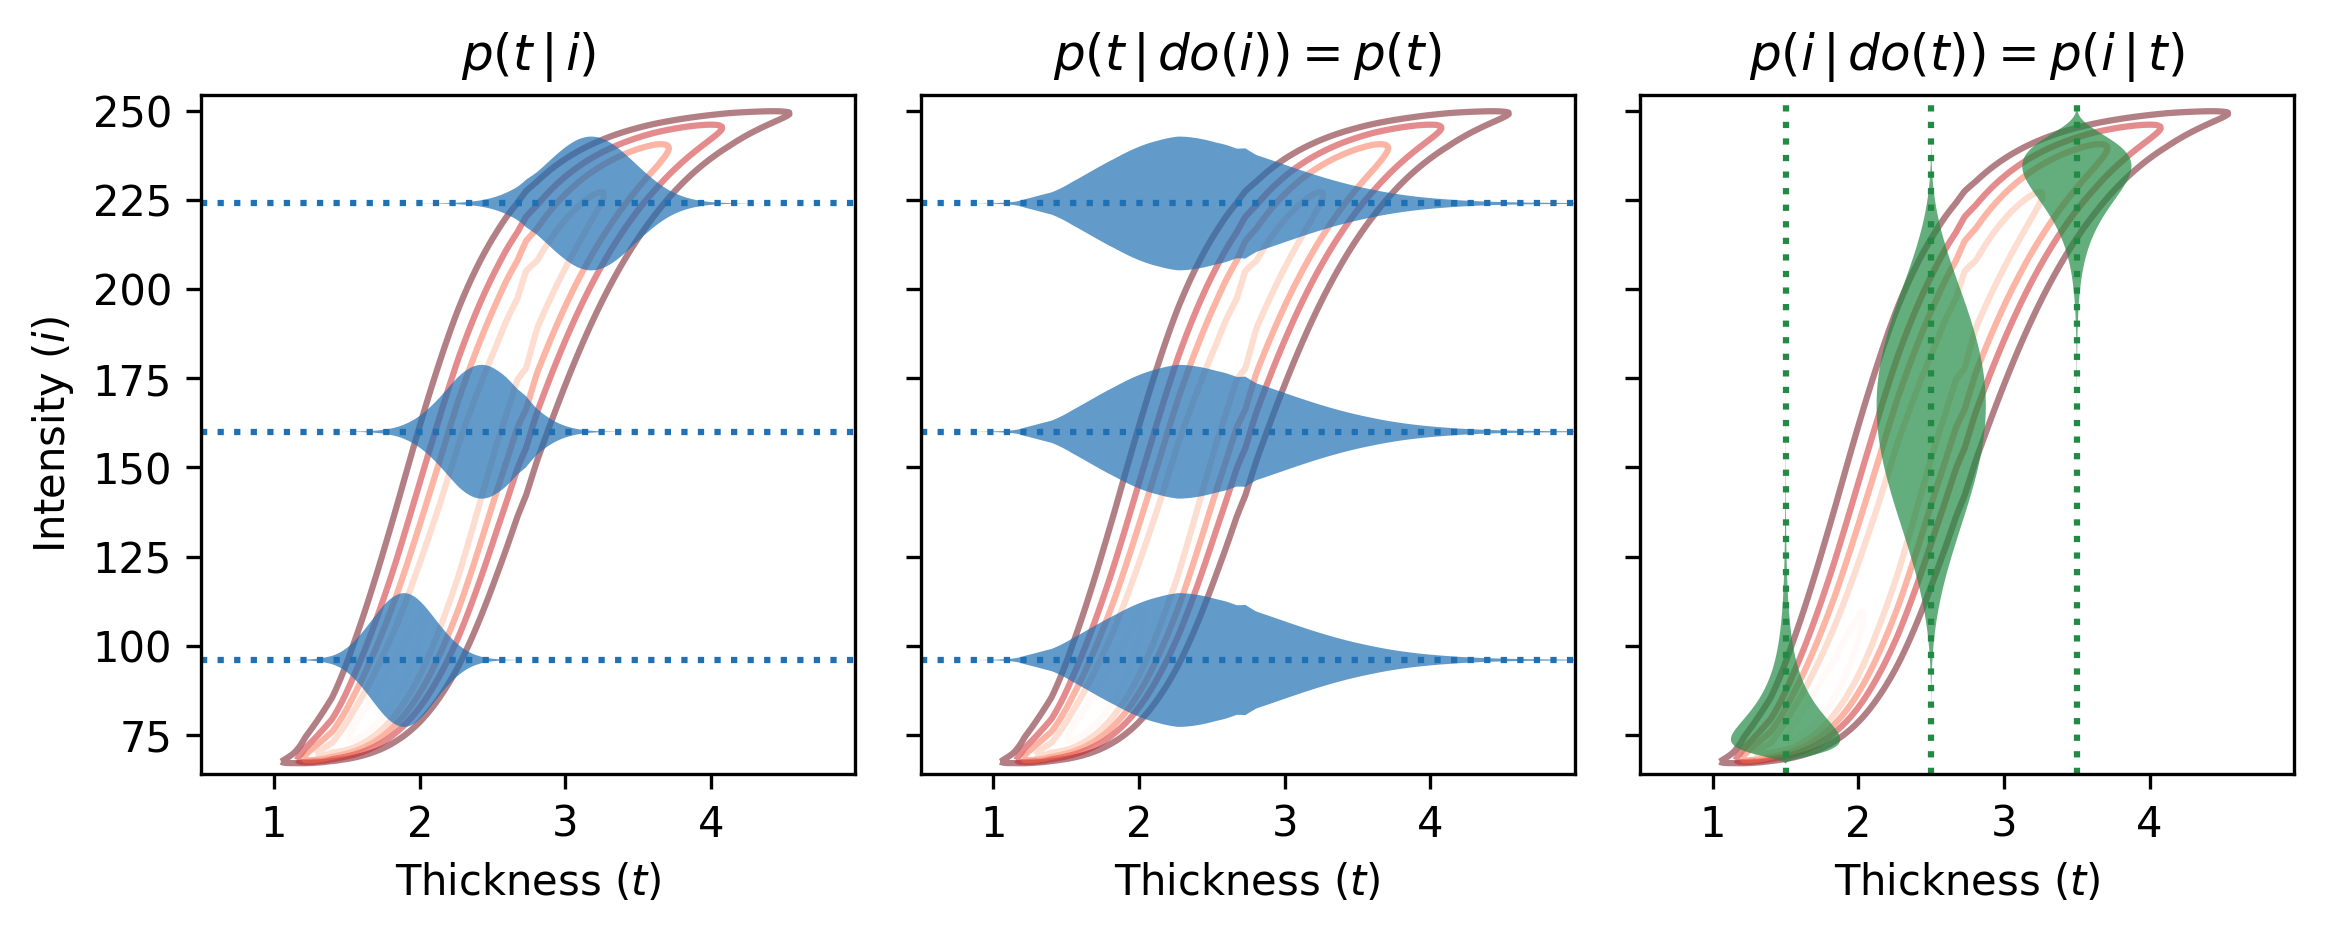

In [24]:
prob = prob_maps['ConditionalVISEM']['$p(t, i)$']['log_prob'].exp().reshape(num_thickness, num_intensity)
thickness = thickness_range.reshape(num_thickness, num_intensity)
intensity = intensity_range.reshape(num_thickness, num_intensity)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))

mi = prob.min()
ma = np.percentile(prob.view(-1), 99.5)
step = (ma - mi) / 5
levels = torch.arange(mi, ma, step) + step
for ax in axs:
    ax.contour(thickness, intensity, prob, cmap=cmaps[0].reversed(), levels=levels, alpha=.5, antialiased=True, zorder=-1)

interv_i = [96, 160, 224]
interv_t = [1.5, 2.5, 3.5]

for do_i in interv_i:
    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(models['ConditionalVISEM'], data={
            'thickness': thickness[:, 0].unsqueeze(1),
            'intensity': torch.full_like(thickness[:, 0], do_i).unsqueeze(1)
        })).get_trace(num_thickness)
        trace.compute_log_prob()

    # Bayes' rule: p(t|i) \propto p(t) * p(i|t)
    prob = (trace.nodes['thickness']['log_prob'] + trace.nodes['intensity']['log_prob']).exp()
    color = cmaps[1](.75)
    my_violinplot(thickness[:, 0], prob, do_i, vert=False, ax=axs[0], width=.75*50,
                  fill_kw=dict(alpha=.7, facecolor=color), line_kw=dict(color=color, ls=':'))

for do_i in interv_i:
    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(
            pyro.do(models['ConditionalVISEM'], data={
                'intensity': torch.full_like(thickness[:, 0], do_i).unsqueeze(1)
            }), data={
            'thickness': thickness[:, 0].unsqueeze(1)
        })).get_trace(num_thickness)
        trace.compute_log_prob()

    prob = (trace.nodes['thickness']['log_prob']).exp()
    color = cmaps[1](.75)
    my_violinplot(thickness[:, 0], prob, do_i, vert=False, ax=axs[1], width=.75*50,#25,
                  fill_kw=dict(alpha=.7, facecolor=color), line_kw=dict(color=color, ls=':'))

for do_t in interv_t:
    with torch.no_grad():
        # Identical results to conditioning:
        # trace = pyro.poutine.trace(pyro.condition(models['ConditionalVISEM'], data={
        #     'thickness': torch.full_like(intensity[0, :], do_t).unsqueeze(1),
        #     'intensity': intensity[0, :].unsqueeze(1)
        # })).get_trace(num_intensity)

        trace = pyro.poutine.trace(pyro.condition(
            pyro.do(models['ConditionalVISEM'], data={
                'thickness': torch.full_like(intensity[0, :], do_t).unsqueeze(1),
            }), data={
            'intensity': intensity[0, :].unsqueeze(1)
        })).get_trace(num_intensity)
        trace.compute_log_prob()
        
    prob = trace.nodes['intensity']['log_prob'].exp()
    color = cmaps[2](.75)
    my_violinplot(intensity[0, :], prob, do_t, vert=True, ax=axs[2], width=.75*1.,
                  fill_kw=dict(alpha=.7, facecolor=color), line_kw=dict(color=color, ls=':'))

axs[0].set_title("$p(t\,|\,i)$")
axs[1].set_title("$p(t\,|\,do(i)) = p(t)$")
axs[2].set_title("$p(i\,|\,do(t)) = p(i\,|\,t)$")
for ax in axs:
    ax.set_xlabel('Thickness ($t$)', fontsize='medium')
axs[0].set_ylabel('Intensity ($i$)', fontsize='medium');

plt.savefig(f'{FIGURE_SAVE_PATH}/morphomnist_cond_vs_do.pdf', bbox_inches='tight');

# Counterfactuals

In [25]:
from pyro.infer.reparam.transform import TransformReparam

from pyro.distributions import Independent, TransformedDistribution
from pyro.distributions.transforms import ComposeTransform

def infer_exogenous(sample, **obs):
    # assuming that we use transformed distributions for everything:
    cond_sample = pyro.condition(sample, data=obs)
    cond_trace = pyro.poutine.trace(cond_sample).get_trace(list(obs.values())[0].shape[0])

    output = {}
    for name, node in cond_trace.nodes.items():
        if 'fn' not in node.keys():
            continue

        fn = node['fn']
        if isinstance(fn, Independent):
            fn = fn.base_dist
        if isinstance(fn, TransformedDistribution):
            output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])

    return output

def generate_counterfactuals(thickness, intensity, do):
    n = thickness.shape[0]
    cond_data = {'thickness': thickness.unsqueeze(1),
                 'intensity': intensity.unsqueeze(1)}
    intervention_data = {k: v.unsqueeze(1) for k, v in do.items()}

    def config(msg):
        return TransformReparam() if isinstance(msg['fn'], TransformedDistribution) else None
    def model(n):
        with pyro.plate('observations', n):
            return models['ConditionalVISEM'].keywords['model'].pgm_model()

    with torch.no_grad():
        exogenous = infer_exogenous(model, **cond_data)
        model = pyro.poutine.reparam(model, config=config)
        counterfactuals = pyro.poutine.do(pyro.poutine.condition(model, exogenous), intervention_data)(n)

    return {'thickness': counterfactuals[0], 'intensity': counterfactuals[1]}

[(2.5802891, 142.01439), (3.632892, 242.2603)]


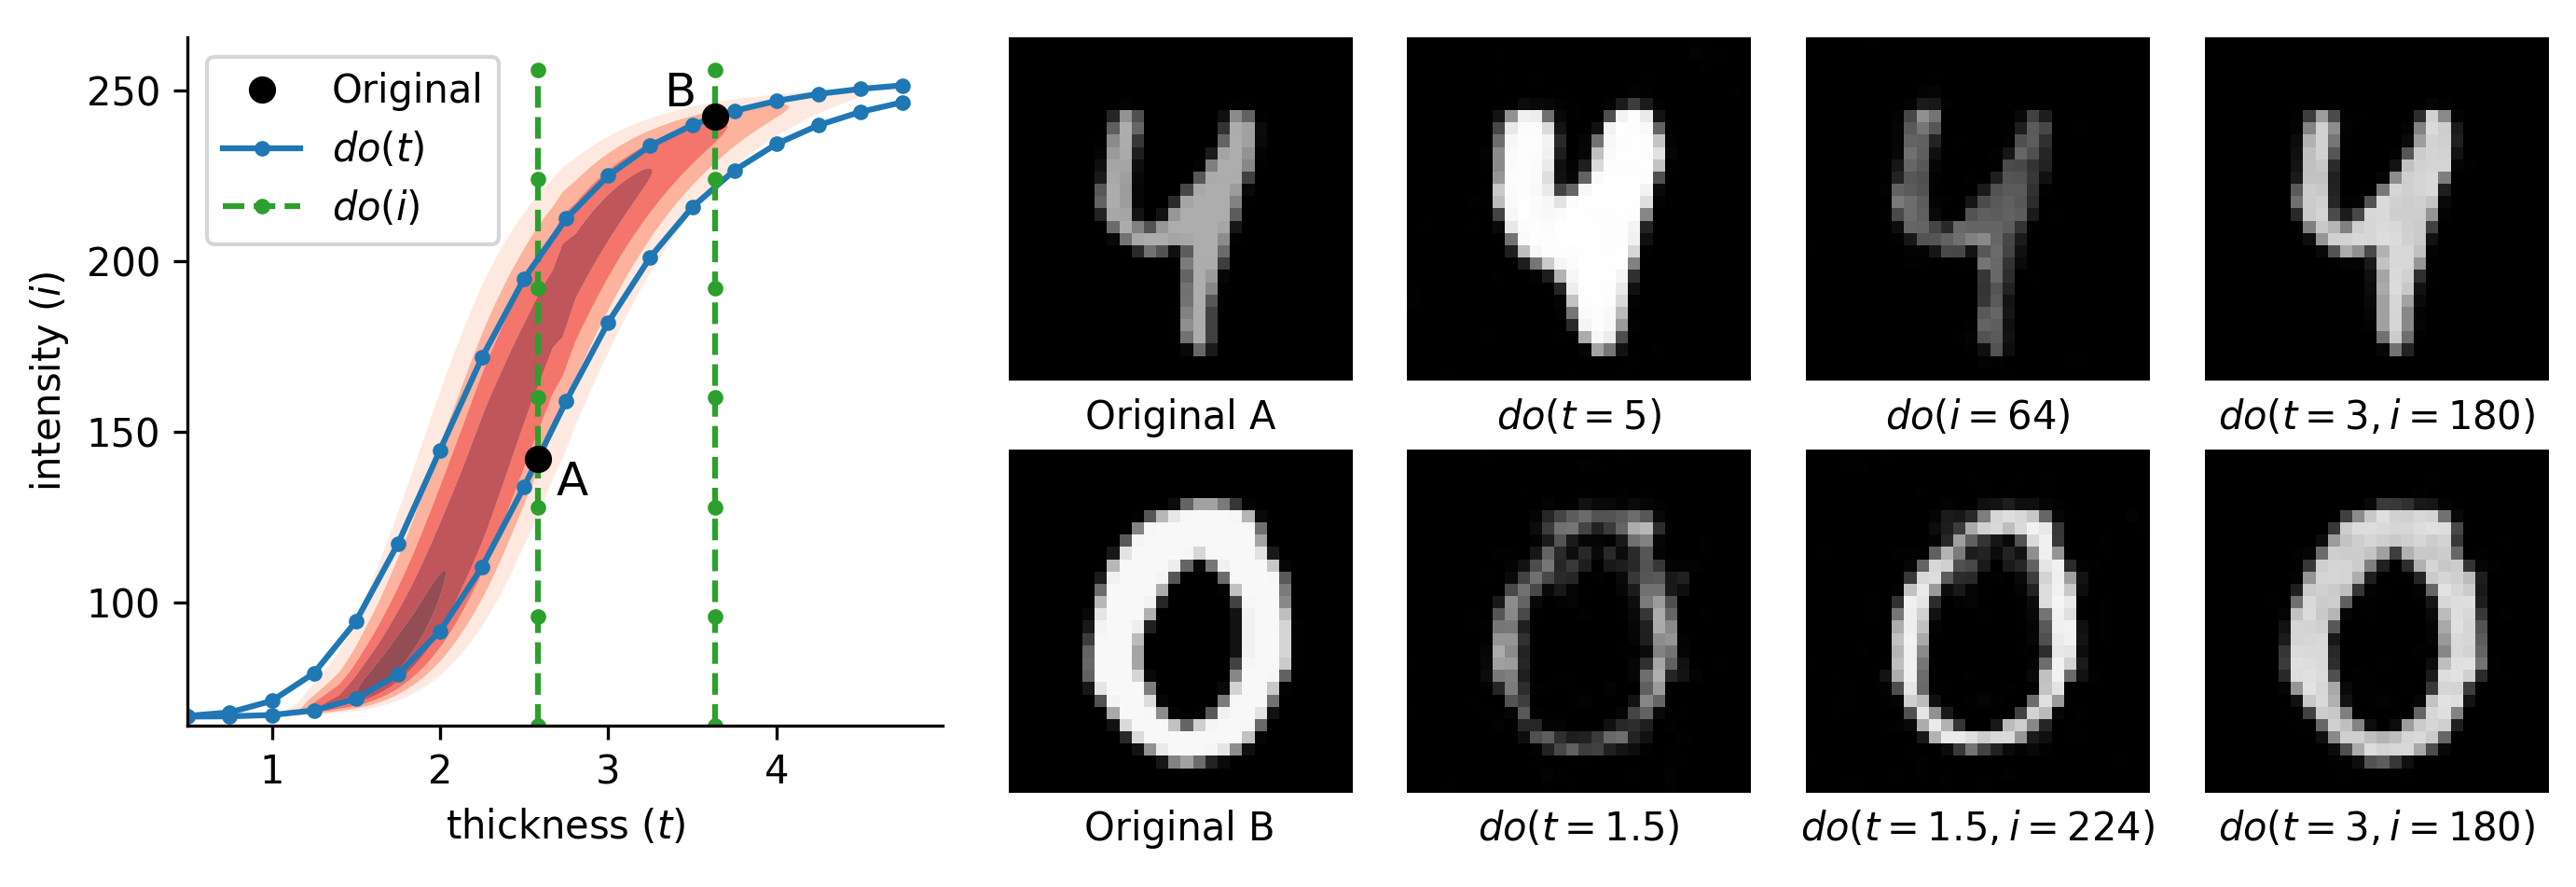

In [26]:
model_name = 'ConditionalVISEM'

v = prob_maps[model_name]['$p(t, i)$']
thickness = v['thickness'].reshape(num_thickness, num_intensity).numpy()
intensity = v['intensity'].reshape(num_thickness, num_intensity).numpy()
log_prob = v['log_prob'].reshape(num_thickness, num_intensity).numpy()
prob = np.exp(log_prob)
mi = prob.min()
ma = np.percentile(prob.flat, 99.5)
step = (ma - mi) / 5
levels = np.arange(mi, ma, step) + step

cmap = cmaps[0]
colour = cmap(.7)

alpha = .7

#################################


def plot_img(orig, counters, fig, gs, row):
    o_ax = fig.add_subplot(gs[row, 0])
    o_ax.imshow(orig['image'], img_cm, vmin=0, vmax=255)
    o_ax.axis('off')
    o_ax.text(0.5, -.05, 'Original ' + 'AB'[row], ha='center', va='top', transform=o_ax.transAxes, fontsize=10)
    
    o_t = orig['thickness'].numpy().squeeze()
    o_i = orig['intensity'].numpy().squeeze()
    
    for i, (annot, counter) in enumerate(counters.items()):
        c_ax = fig.add_subplot(gs[row, i + 1])
        c_ax.imshow(counter['image'], img_cm, vmin=0, vmax=255)
        c_ax.text(0.5, -.05, annot, ha='center', va='top', transform=c_ax.transAxes, fontsize=10)
        c_ax.axis('off')
    
        c_t = counter['thickness']
        c_i = counter['intensity']


def prep_sample_data(intervention, idx):
    orig_data = prep_data(test_data[idx])
    
    cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
    counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, 32)

    return {
        'image': counterfactual['x'].numpy().squeeze(),
        'thickness': counterfactual['thickness'].numpy().squeeze(),
        'intensity': counterfactual['intensity'].numpy().squeeze()
    }

fig = plt.figure(figsize=(10, 3))
wid, hei = fig.get_size_inches()
gs = fig.add_gridspec(2, 5, left=hei/wid, right=1, top=1, bottom=.1, wspace=.1, hspace=.2)

i1_idx = 42

i1_data = test_data[i1_idx]
plot_img(i1_data, {
    '$do(t=5)$': prep_sample_data({'thickness': 5.}, i1_idx),
    '$do(i=64)$': prep_sample_data({'intensity': 64.}, i1_idx),
    '$do(t=3,i=180)$': prep_sample_data({'thickness': 3., 'intensity': 180.}, i1_idx)
}, fig, gs, 0)


i2_idx = 13

i2_data = test_data[i2_idx]
plot_img(i2_data, {
    '$do(t=1.5)$': prep_sample_data({'thickness': 1.5}, i2_idx),
    '$do(t=1.5,i=224)$': prep_sample_data({'thickness': 1.5, 'intensity': 224.}, i2_idx),
    '$do(t=3,i=180)$': prep_sample_data({'thickness': 3., 'intensity': 180.}, i2_idx)
}, fig, gs, 1)

#################################

# ax = fig.add_subplot(gs[:2, :2])
ax = fig.add_axes([.1/wid, .18, (.9*hei)/wid, .82])
ax.contourf(thickness, intensity, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')


anchors = [(d['thickness'].item(), d['intensity'].item()) for d in [i1_data, i2_data]]
print(anchors)

for i, (t0, i0) in enumerate(anchors):
    inter = torch.arange(.5, 5., .25)
    cft = generate_counterfactuals(torch.tensor([t0]), torch.tensor([i0]),
                                  {'thickness': inter})
    ht, = ax.plot(cft['thickness'], cft['intensity'], '.-C0')

    inter = torch.arange(64., 256.1, 32.)
    cfi = generate_counterfactuals(torch.full_like(inter, t0), torch.full_like(inter, i0),
                                  {'intensity': inter})
    hi, = ax.plot(cfi['thickness'], cfi['intensity'], '.--C2')
    h0, = ax.plot(t0, i0, 'ok')
    xytext = [(-9, 6), (9, -6)][::-1]
    ax.annotate('AB'[i], (t0, i0), xytext[i], textcoords='offset points',
                ha='center', va='center', fontsize=12)
ax.legend([h0, ht, hi], ["Original", "$do(t)$", "$do(i)$"])
ax.set(xlabel='thickness ($t$)', ylabel='intensity ($i$)')

sns.despine()
plt.savefig(f'{FIGURE_SAVE_PATH}/morphomnist_cf_trajectories.pdf', bbox_inches='tight')
plt.show()

# Counterfactual Traversal

In [27]:
def plot_gen_intervention_range(model_name, all_interventions, save_name, normalise_all=True, num_samples=32):
    
    
    num_idx = len(all_interventions)
    num_inter = len(all_interventions[0][1])
    
    hrs = [0.2 if ((i + 1) % 3) == 0 else 1 for i in range(2 * num_idx + num_idx - 1)]
    fig, ax = plt.subplots(2 * num_idx + num_idx - 1, (num_inter + 1), figsize=(1.8 * (num_inter + 1), 4*num_idx),
                           gridspec_kw=dict(wspace=0, hspace=0, height_ratios=hrs))
    lim = 0
    
    for cur_ex, (idx, interventions) in enumerate(all_interventions):
        orig_data = prep_data(test_data[idx])

        imgs = []
        for intervention in interventions:
            pyro.clear_param_store()
            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

            imgs += [counterfactual['x']]

            diff = (orig_data['x'] - imgs[-1]).squeeze()

            lim = np.maximum(lim, diff.abs().max())
            
        x_test = orig_data['x']
        ax[cur_ex * 3, 0].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        ax[cur_ex * 3, 0].set_title('Original')

        for i, intervention in enumerate(interventions):
            x = imgs[i]
            
            diff = (x_test - x).squeeze()
            if not normalise_all:
                lim = diff.abs().max()

            ax[cur_ex * 3, i + 1].set_title(fmt_intervention(intervention))
            ax[cur_ex * 3, i + 1].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

            ax[cur_ex * 3 + 1, i + 1].imshow(diff, 'seismic', clim=[-lim, lim])
        
        att_str = '$t={thickness}$\n$i={intensity}$'.format(
            **{att: value_fmt[att](orig_data[att].item()) for att in ('thickness', 'intensity')}
        )
        
        ax[cur_ex * 3 + 1, 0].text(0.5, 0.5, att_str, horizontalalignment='center',
                                   verticalalignment='center', transform=ax[cur_ex * 3 + 1, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
        
    for axi in ax.ravel():
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
        
    plt.show()

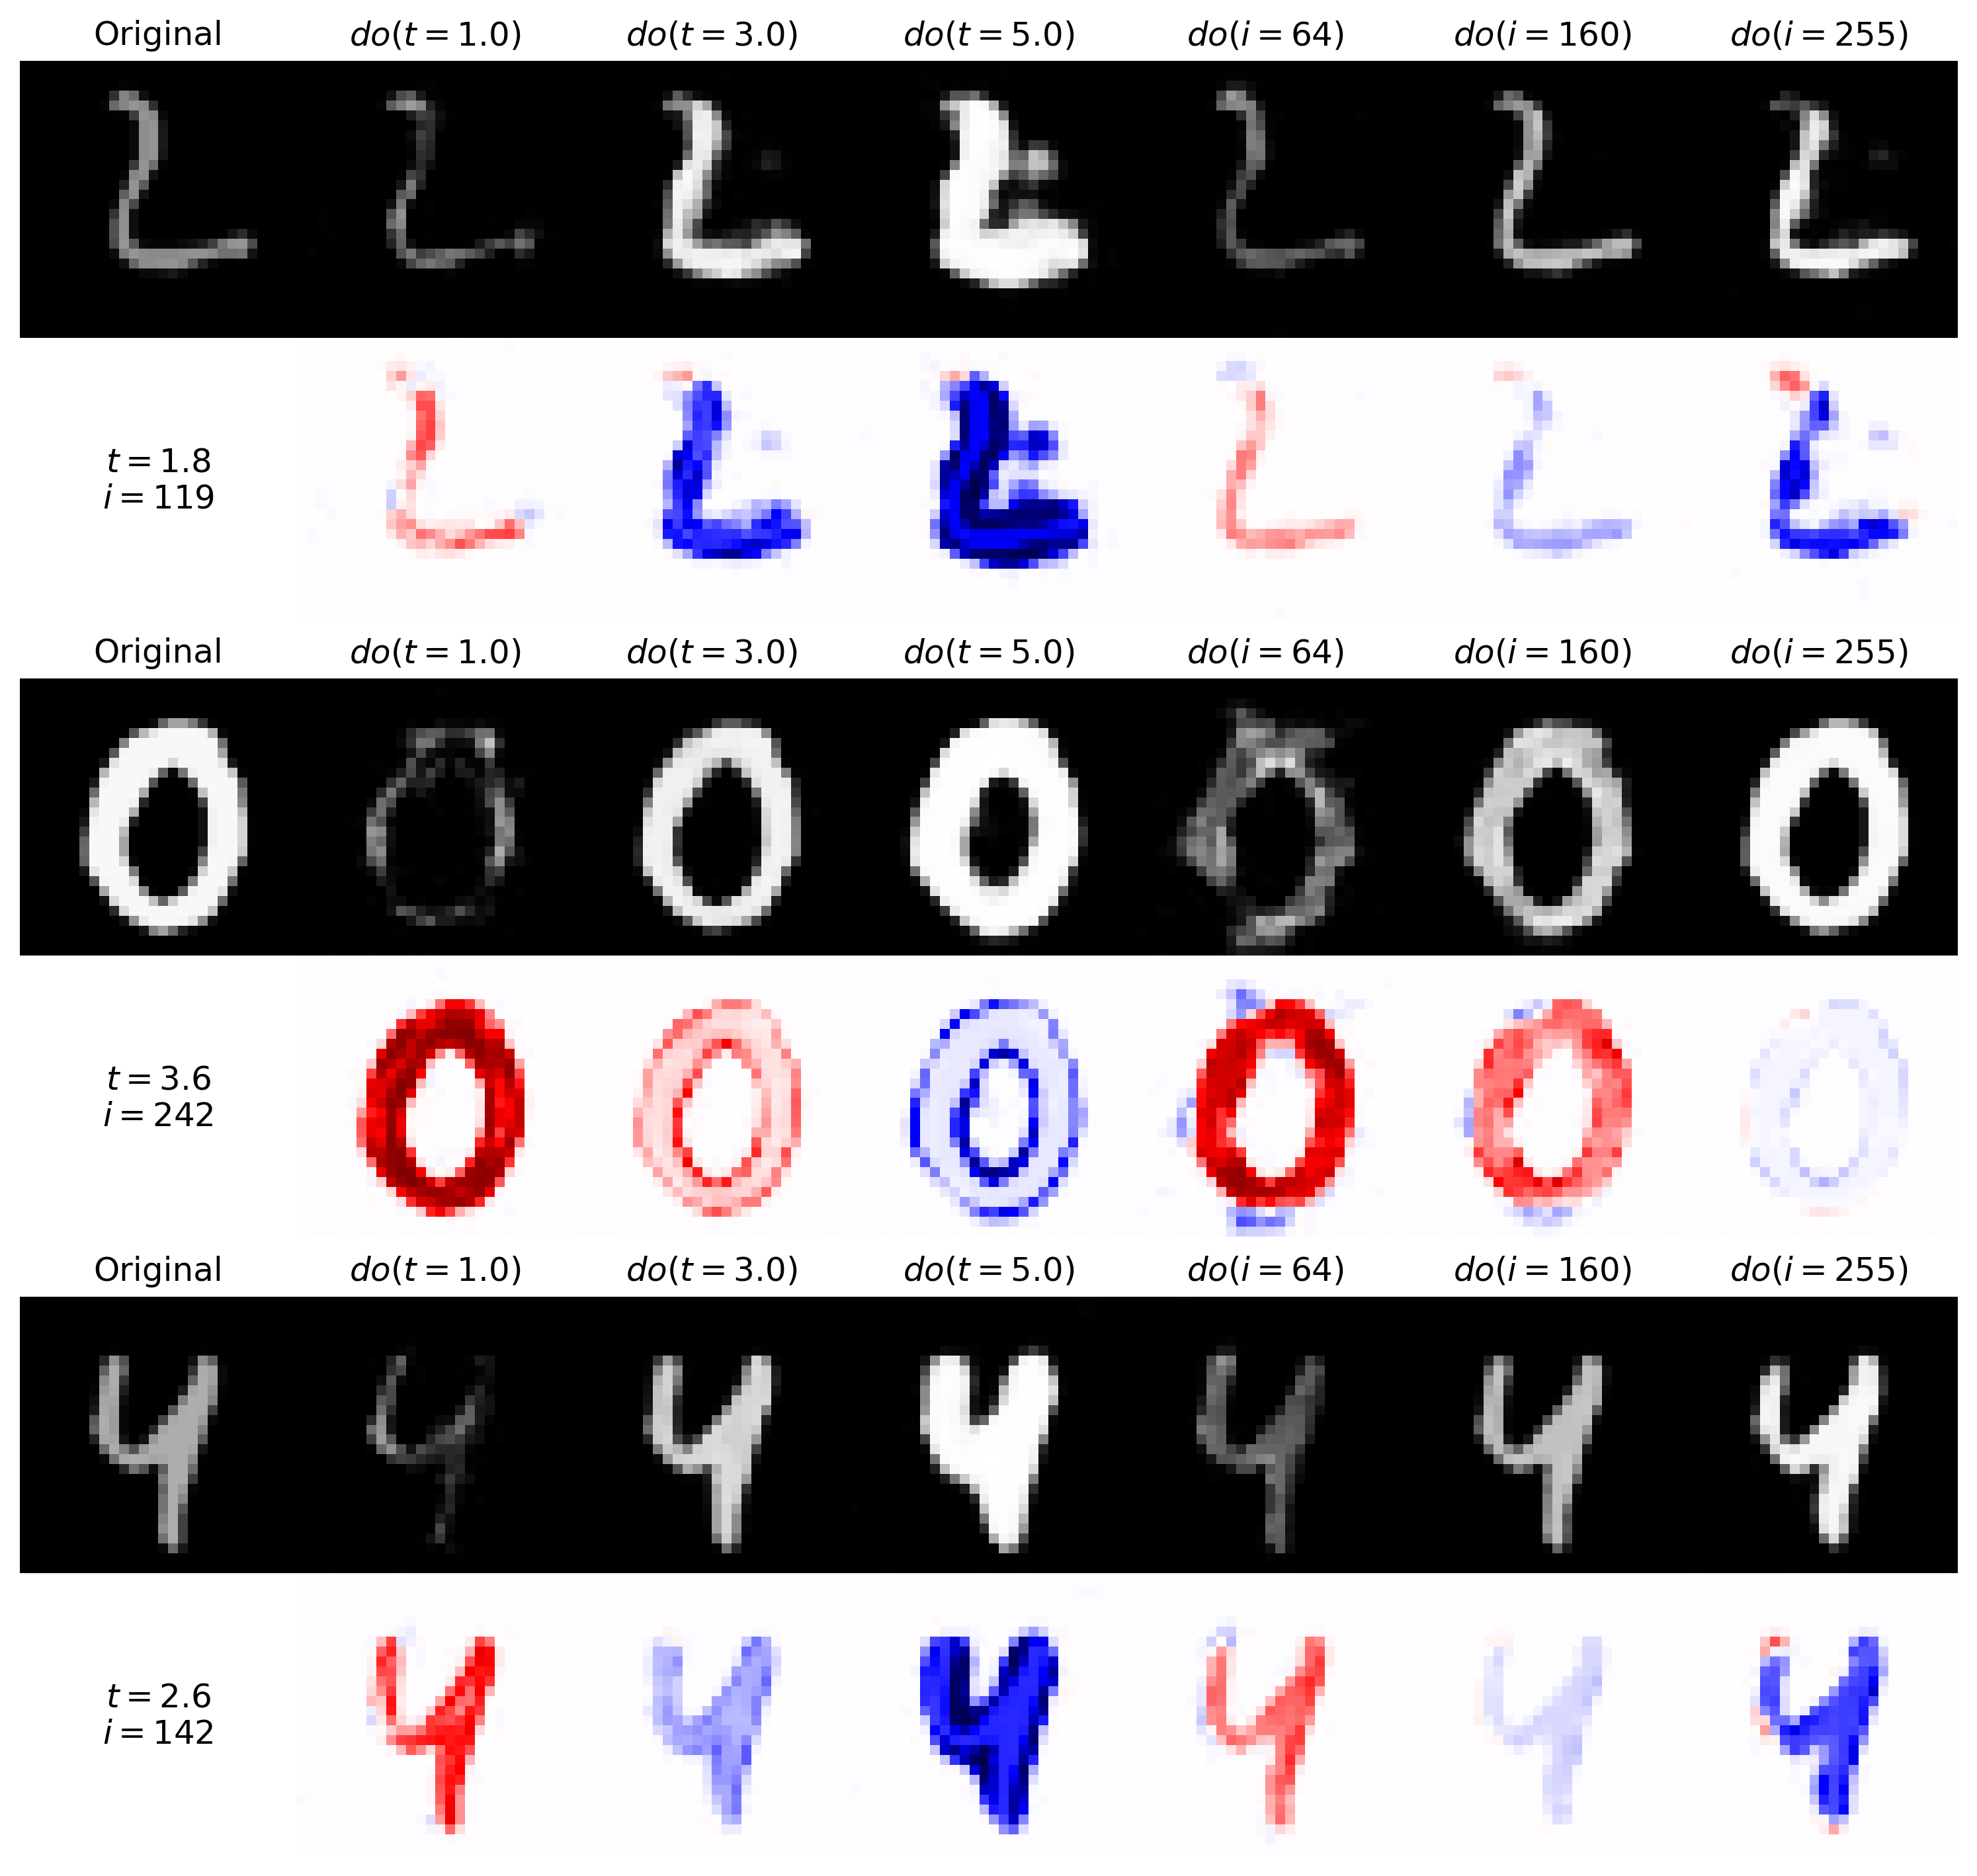

In [28]:
model_name = 'ConditionalVISEM'

interventions = [
    (1337, [
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
    ]),
    (13, [
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
    ]),
    (42, [
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
    ])
]

save_name = 'counterfactual_range'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)